# Agentic system for image generation - text editing


## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../.."
sys.path.append(os.path.abspath(module_path))

## 1. Create Bedrock client

In [3]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-5-V-2-Sonnet-CRI': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid

## 2. LLM 정의

In [5]:
from utils.bedrock import bedrock_model
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-V-2-Sonnet-CRI"),
    #model_id=bedrock_info.get_model_id(model_name="Nova-Pro-CRI"),
    bedrock_client=boto3_bedrock,
    stream=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    inference_config={
        'maxTokens': 4096,
        'stopSequences': ["\n\nHuman"],
        'temperature': 0.01,
        #'topP': ...,
    }
    #additional_model_request_fields={"top_k": 200}
)

- "SD-3-5-Large": "stability.sd3-5-large-v1:0",
- "SD-Ultra": "stability.stable-image-ultra-v1:1",
- "SD-3-Large": "stability.sd3-large-v1:0"

In [7]:
image_generation_model = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="SD-Ultra"),
    bedrock_client=boto3_bedrock
)

## 3. Analysis

In [8]:
import io
import time
import json
import random
import pprint
import base64
import traceback
from PIL import Image
from termcolor import colored
import matplotlib.pyplot as plt

from textwrap import dedent
from utils.bedrock import bedrock_utils
from typing import TypedDict, Optional, List
from src.genai_anaysis import llm_call
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

In [9]:
class TimeMeasurement:
    def __init__(self):
        self.start_time = None
        self.measurements = {}

    def start(self):
        self.start_time = time.time()

    def measure(self, section_name):
        if self.start_time is None:
            raise ValueError("start() 메서드를 먼저 호출해야 합니다.")
        
        end_time = time.time()
        elapsed_time = end_time - self.start_time
        self.measurements[section_name] = elapsed_time
        self.start_time = end_time  # 다음 구간 측정을 위해 시작 시간 재설정

    def reset(self, ):
        self.measurements = {}

    def print_measurements(self):
        for section, elapsed_time in self.measurements.items():
            #print(f"{section}: {elapsed_time:.5f} 초")
            print(colored (f"\nelapsed time: {section}: {elapsed_time:.5f} 초", "red"))

In [ ]:
def _body_generator(pos_prompt, neg_prompt="", condition_image=None, condition_strength=None, seed=1):
    
    #prompt, negative_prompt, mode, strength, seed, output_format, image, aspect_ratio
    
    #condition_image=condition_image,
    #condition_strength=0.3,
    
    if condition_image == None:
        body_dict = {
            "prompt": pos_prompt,
            "negative_prompt": neg_prompt,
            "mode": "text-to-image",
            "aspect_ratio": "1:1",  # Default 1:1. Enum: 16:9, 1:1, 21:9, 2:3, 3:2, 4:5, 5:4, 9:16, 9:21.
            "output_format": "png",
            "seed": seed
        }
    else:
        body_dict = {
            "prompt": pos_prompt,
            "negative_prompt": neg_prompt,
            "mode": "image-to-image",
            "strength": condition_strength,
            "image": condition_image,
            "output_format": "png",
            "seed": seed
        }

    return json.dumps(body_dict)

def _png_to_bytes(file_path):
    try:
        with open(file_path, "rb") as image_file:
            # 파일을 바이너리 모드로 읽기
            binary_data = image_file.read()

            # 바이너리 데이터를 base64로 인코딩
            base64_encoded = base64.b64encode(binary_data)

            # bytes 타입을 문자열로 디코딩
            base64_string = base64_encoded.decode('utf-8')

            return binary_data, base64_string

    except FileNotFoundError:
        return "Error: 파일을 찾을 수 없습니다."
    except Exception as e:
        return f"Error: {str(e)}"
        
def show_save_image(base64_string):
    try:

        # base64 문자열을 디코딩하여 바이너리 데이터로 변환
        image_data = base64.b64decode(base64_string)

        # 바이너리 데이터를 이미지로 변환
        image = Image.open(io.BytesIO(image_data))

        fig, (ax1) = plt.subplots(1, 1, figsize=(15, 7))
        ax1.imshow(image)
        ax1.axis('off')
        ax1.set_title('Generated Image')

        plt.tight_layout()  # 레이아웃 조정
        plt.show()

        # save images
        img_path = './generated_imgs/GENERATED_IMAGE.png'
        image.save(img_path, "PNG")

        return img_path

    except Exception as e:
        print(f"Error: 이미지를 표시하는 데 실패했습니다. {str(e)}")

In [ ]:
_, base64_string = _png_to_bytes("./generated_imgs/GENERATED_IMAGE.png") 

body = _body_generator(
    pos_prompt="An icy landscape. A vast expanse of snow-covered mountain peaks stretches endlessly. Beneath them is a dense forest and a colossal frozen lake. Three people are boating in three boats separately in the lake. Not far from the lake, a volcano threatens eruption, its rumblings felt even from afar. Above, a ferocious red dragon dominates the sky and commands the heavens, fueled by the volcano's relentless energy flow. photorealistic, hyperrealistic, high definition, high resolution, highly detailed",
    condition_image=base64_string,
    condition_strength=0.7,
    seed=2323
)
response = image_generation_model.bedrock_client.invoke_model(
    body=body,
    modelId=image_generation_model.model_id
)
print (image_generation_model.model_id)
response_body = json.loads(response.get("body").read())
base64_image = response_body.get("images")[0]
condition_image = show_save_image(base64_image)

In [ ]:
_, base64_string = _png_to_bytes("./generated_imgs/GENERATED_IMAGE.png") 

body = _body_generator(
    pos_prompt="Above, a ferocious red dragon dominates the sky and commands the heavens, fueled by the volcano's relentless energy flow. photorealistic, hyperrealistic, high definition, high resolution, highly detailed",
    condition_image=base64_string,
    condition_strength=0.7,
    seed=2323
)
response = image_generation_model.bedrock_client.invoke_model(
    body=body,
    modelId=image_generation_model.model_id
)
print (image_generation_model.model_id)
response_body = json.loads(response.get("body").read())
base64_image = response_body.get("images")[0]
condition_image = show_save_image(base64_image)

In [ ]:
_, base64_string = _png_to_bytes("./generated_imgs/GENERATED_IMAGE.png") 

body = _body_generator(
    pos_prompt="Above, a massive and ferocious red dragon dominates the sky and commands the heavens, fueled by the volcano's relentless energy flow. photorealistic, hyperrealistic, high definition, high resolution, highly detailed",
    condition_image=base64_string,
    condition_strength=0.7,
    seed=2323
)
response = image_generation_model.bedrock_client.invoke_model(
    body=body,
    modelId=image_generation_model.model_id
)
print (image_generation_model.model_id)
response_body = json.loads(response.get("body").read())
base64_image = response_body.get("images")[0]
condition_image = show_save_image(base64_image)

In [ ]:
body = _body_generator(
    pos_prompt="Two hot dogs sit on a green plate near a soda cup which are sitting on a white picnic table, while a red bike (on the left of image) and a blue car (on the right of image)are parked nearby. A high-resolution DSLR photograph",
    seed=2323
)
response = image_generation_model.bedrock_client.invoke_model(
    body=body,
    modelId=image_generation_model.model_id
)
print (image_generation_model.model_id)
response_body = json.loads(response.get("body").read())
base64_image = response_body.get("images")[0]
condition_image = show_save_image(base64_image)

In [ ]:
condition_image

In [ ]:
#_body_generator(pos_prompt, neg_prompt="", condition_image=None, condition_strength=None, seed=1):

img_bytes, img_base64 = _png_to_bytes(condition_image)

body = _body_generator(
    pos_prompt='remove carrot',
    condition_image=img_base64,
    condition_strength=0.3, # A value of 0 would yield an image that is identical to the input. A value of 1 would be as if you passed in no image at all. Range: [0, 1]
    
)
response = image_generation_model.bedrock_client.invoke_model(
    body=body,
    modelId=image_generation_model.model_id
)
response_body = json.loads(response.get("body").read())
base64_image = response_body.get("images")[0]
condition_image = show_save_image(base64_image)

In [ ]:
     
                    - Maintain the same artistic style keywords from previous prompt
                - Keep consistent quality enhancers
                - Use matching lighting and atmosphere descriptions
                - Preserve camera angle and perspective terms
                - Maintain similar level of detail in descriptions
                - Use consistent rendering style indicators
                
    
    You are an agent that plans steps for stepwise image generation based on user requests. Your role is to:

                1. Break down the user's request into manageable steps, considering:
                   - Each step's output should maintain consistency with the previous step's image
                   - Only segmentation control mode is available from step 2 onwards
                   - Start with basic composition and layout, then gradually add details
                   - Set appropriate control strength for each step to ensure smooth transitions
                
                2. For each step, you should provide:
                   - Step description
                   - Selected control mode (NONE for step 1, SEGMENTATION for subsequent steps)
                   - Control strength (0.0-1.0, not applicable for step 1)
                   - Image generation prompt that:
                     * Maintains key elements from previous steps
                     * Clearly specifies what new elements/details to add
                     * Uses image captioning style (e.g., "A photo of X, showing Y, with Z in the background")
                     * Uses appropriate style and composition keywords for consistency
                
                Guidelines for planning steps:
                
                1. First Step (Crucial Composition and Subject Stage):
                   - No control mode is available (use "NONE" or "UNCONDITIONAL")
                   - Control strength should be null or 0 (not applicable)
                   - Critical for establishing overall scene composition AND main subjects:
                     * Include ALL major elements that affect scene layout
                     * Include primary subjects with appropriate emphasis and scale
                     * Set up primary spatial relationships and viewpoint
                     * Consider foreground/background structure
                     * Plan for elements that require specific positioning
                   - Elements requiring first-step inclusion:
                     * Primary subjects (must be prominently featured)
                     * Multiple objects with specific spatial relationships
                     * Elements requiring particular viewing angles
                     * Background elements that affect overall composition
                   - Composition priorities:
                     * Ensure primary subjects are prominently sized and positioned
                     * Maintain appropriate scale relationships between elements
                     * Create clear visual hierarchy emphasizing main subjects
                   - Provide comprehensive prompt prioritizing subject emphasis
                   - This will serve as the foundational layout for subsequent refinements
                
                2. Middle Steps (From Step 2 onwards):
                   - Use segmentation control mode for adding or modifying objects
                   - Control strength guidelines:
                     * For major new elements: 0.4-0.5 (allows significant changes while maintaining basic structure)
                     * For moderate additions: 0.5-0.7 (balanced flexibility for new elements)
                     * For minor modifications: 0.7-0.9 (strongly preserves existing elements)
                   - Each prompt should explicitly reference maintaining previous elements
                   - Add new elements gradually, not all at once
                   - Consider the scale and impact of new elements when selecting control strength
                
                3. Final Step (Optional, if needed): 
                   - Use segmentation mode for final refinements and adjustments
                   - Control strength: 0.8-0.9 (ensures high fidelity to previous step while allowing enhancements)
                   - Focus on enhancing overall composition and element relationships
                   - Ensure prompt maintains all previous elements while adding final touches
                
                Control Strength Guidelines:
                - Not applicable for Step 1
                - 0.4-0.5: For major compositional changes only
                - 0.5-0.6: For significant detail additions while maintaining realism
                - 0.6-0.7: For moderate refinements and enhancements
                - 0.7-0.8: For subtle adjustments
                - 0.8-0.9: For final refinements while maintaining photorealism
                - Above 0.9: Not recommended as it may result in over-processed appearance
                
                Composition Planning Strategy:
                1. Subject and Layout Analysis:
                   - Identify primary subjects from user request
                   - Analyze the request for elements that affect overall layout
                   - Determine required scale and emphasis of main subjects
                   - Plan which elements must be included in first step
                   - Consider how later additions might interact with initial composition
                
                2. Elements to Include in First Step:
                   - Primary subjects that need prominent emphasis
                   - Major background elements (buildings, landscapes, etc.)
                   - Objects requiring specific spatial relationships
                   - Elements that define the viewing angle or perspective
                   - Any items that other elements will need to be positioned relative to
                
                3. Subject Emphasis Guidelines:
                   - Position primary subjects in visually dominant locations
                   - Ensure appropriate size and scale for main subjects
                   - Use composition techniques to draw attention to key elements:
                     * Foreground placement for emphasis
                     * Contrasting sizes between primary and secondary elements
                     * Clear separation from background elements
                   - Consider viewing angle that best showcases primary subjects
                
                4. Elements Suitable for Later Steps:
                   - Additional details that follow established composition
                   - Secondary objects that complement main subjects
                   - Composition and lighting enhancements
                   - Elements that don't require major compositional changes
                
                Scene Composition Guidelines:
                1. Foreground vs Background:
                   - When adding background elements:
                     * Use lower control strength (0.4-0.5)
                     * Place background description early in the prompt
                     * Be specific about spatial relationships
                     * Example: "A photo showing a blue sedan car in the background, with [foreground elements] in the foreground"
                   - When modifying foreground elements:
                     * Use higher control strength (0.6-0.8)
                     * Focus on maintaining clear separation between fore/background
                     * Be explicit about layering and depth
                
                2. Spatial Relationships:
                   - Always specify clear positions (left, right, background, foreground)
                   - Use distance indicators (near, far, closer to, behind)
                   - Consider depth and perspective in the scene
                   - Example: "A blue sedan parked in the far background, with a picnic table in the near foreground"
                
                Special Cases for Major Elements:
                1. When adding completely new, large, or dominant elements:
                   - Use lower control strength (0.4-0.5)
                   - Place the new element at the beginning of the prompt
                   - Provide detailed descriptions of the new element
                   - Consider the element's role in overall composition (foreground/background)
                   - Example: "A photo of a massive red dragon in the sky" instead of "A landscape with a dragon"
                
                2. For challenging elements (creatures, vehicles, dramatic effects):
                   - Be more specific about characteristics (size, color, texture)
                   - Add relevant style emphasizers (realistic, detailed, majestic)
                   - Consider breaking the addition into sub-steps if needed
                   - Avoid burying important new elements in the middle of the prompt
                   - Be explicit about viewing angle and perspective
                
                Required Output Format:
                DO NOT include any text outside the JSON format in the response
                You must provide your response in the following JSON format:
                {
                    "total_steps": <number_of_steps>,
                    "steps": [
                        {
                            "step_number": <number>,
                            "description": <string>,
                            "control_mode": <"NONE" for step 1, "SEGMENTATION" for others>,
                            "control_strength": <null/0 for step 1, float for others>,
                            "prompt": {
                                "positive": <string>,
                                "negative": <string>
                            },
                        },
                        ...
                    ],
                }
                
                Prompt Writing Guidelines:
                - Use image captioning style for all prompts
                - Start with "A photo of" or similar natural description
                - When adding major new elements:
                  * Place them at the start of the prompt
                  * Provide detailed, specific descriptions
                  * Example: "A photo of a massive red dragon with glowing scales" vs "A photo of mountains with a dragon"
                - When establishing scene composition:
                  * Clearly state spatial relationships
                  * Use depth indicators (foreground, background, near, far)
                  * Specify viewing angles when relevant
                - Describe main subjects first, then background/details
                - Use clear spatial relationships (in the foreground, background, left, right, etc.)
                - Keep descriptions natural and flowing like human captions
                - Keep the total prompt length under 10,000 characters
                - Write prompts as concisely as possible
                - Include relevant style keywords at the end of the description
                - For challenging or complex elements:
                  * Be extremely specific about characteristics
                  * Use multiple descriptive adjectives
                  * Consider adding emphasis words (majestic, dramatic, powerful)
                  * Include relevant technical details when appropriate
                
                Remember:
                - First step is unconditional (no control mode or strength)
                - Minimize the number of steps (1-2 maximum)
                - Prefer fewer steps when possible
                - Ensure each step builds naturally upon the previous one
                - Pay special attention to foreground/background relationships
                - Be specific about spatial relationships and compositions
                - Select control strength values that ensure smooth transitions between steps

### 3.1 Agent state 

In [10]:
class GraphState(TypedDict):
    ask: str
    
    total_steps: int
    steps: List[str]

    seed: int
    current_step: int
    condition_image: str

    suggestions: str
    prompt_repo: dict
    retry_count: int
    prev_node: str
    should_regeneration: str

    reset: bool

In [ ]:
- 0.1-0.3: Minimal changes, preserving most original features
                - 0.3-0.4: Subtle adjustments while maintaining strong resemblance
                - 0.4-0.6: Optimal range for balanced transformation:
                  * Preserves key features while allowing creative variations
                  * Best for most image generations
                  * Maintains meaningful connection to original
                - 0.6-0.7: Higher creative variation with some feature preservation
                - 0.7-0.8: Significant creative changes with potential feature distortion
                - Above 0.8: Extensive transformation with minimal original preservation
                
                
                Control Strength Selection:
                - 0.4-0.5: Use for major compositional changes or significant new elements
                - 0.5-0.7: Use for adding moderate details or secondary elements
                - 0.7-0.9: Use for minor refinements and subtle adjustments
                - Consider the cumulative effect of multiple changes when selecting strength
                - Prioritize maintaining existing elements while incorporating changes
                
                프롬프트 모디케이션
                - Incorporate suggestions into the original prompt
                   - Maintain the core elements and structure
                   - Ensure proper integration of improvements
                   - Preserve essential spatial relationships
                   - Keep the total prompt length under 1024 characters
                   - Write prompts as concisely as possible
                   - Maintain style consistency with the origin image

In [44]:
class genai_analyzer():

    def __init__(self, **kwargs):

        self.llm=kwargs["llm"]
        self.image_generation_model = kwargs["image_generation_model"]
        self.state = GraphState

        self.llm_caller = llm_call(
            llm=self.llm,
            verbose=False
        ) 

        self._graph_definition()
        self.messages = []

        self.timer = TimeMeasurement()

    def _get_string_from_message(self, message):
        return message["content"][0]["text"]

    def _get_message_from_string(self, role, string, imgs=None):
        
        message = {
            "role": role,
            "content": []
        }
        
        if imgs is not None:
            for img in imgs:
                img_message = {
                    "image": {
                        "format": 'png',
                        "source": {"bytes": img}
                    }
                }
                message["content"].append(img_message)
        
        message["content"].append({"text": dedent(string)})

        return message
    
    def _png_to_bytes(self, file_path):
        try:
            with open(file_path, "rb") as image_file:
                # 파일을 바이너리 모드로 읽기
                binary_data = image_file.read()
                
                # 바이너리 데이터를 base64로 인코딩
                base64_encoded = base64.b64encode(binary_data)
                
                # bytes 타입을 문자열로 디코딩
                base64_string = base64_encoded.decode('utf-8')
                
                return binary_data, base64_string
                
        except FileNotFoundError:
            return "Error: 파일을 찾을 수 없습니다."
        except Exception as e:
            return f"Error: {str(e)}"

    def show_save_image(self, base64_string):
        try:
            
            # base64 문자열을 디코딩하여 바이너리 데이터로 변환
            image_data = base64.b64decode(base64_string)
            
            # 바이너리 데이터를 이미지로 변환
            image = Image.open(io.BytesIO(image_data))

            fig, (ax1) = plt.subplots(1, 1, figsize=(15, 7))
            ax1.imshow(image)
            ax1.axis('off')
            ax1.set_title('Generated Image')

            plt.tight_layout()  # 레이아웃 조정
            plt.show()
            
            # save images
            img_path = './generated_imgs/GENERATED_IMAGE.png'
            image.save(img_path, "PNG")
            
            return img_path
            
        except Exception as e:
            print(f"Error: 이미지를 표시하는 데 실패했습니다. {str(e)}")
            
    def _body_generator(self, pos_prompt, neg_prompt="", condition_image=None, control_strength=None, seed=1):
    
        if condition_image == None:
            self.image_generation_model.model_id = "stability.stable-image-ultra-v1:1"
            print (f'Image generator: SD-Ultra')
            body_dict = {
                "prompt": pos_prompt,
                "negative_prompt": neg_prompt,
                "mode": "text-to-image",
                "aspect_ratio": "1:1",  # Default 1:1. Enum: 16:9, 1:1, 21:9, 2:3, 3:2, 4:5, 5:4, 9:16, 9:21.
                "output_format": "png",
                "seed": seed
            }
        else:
            self.image_generation_model.model_id = "stability.sd3-5-large-v1:0"
            print (f'Image generator: SD-3-5-Large')
            body_dict = {
                "prompt": pos_prompt,
                "negative_prompt": neg_prompt,
                "mode": "image-to-image",
                "strength": control_strength, # nova랑 반대
                "image": condition_image,
                "output_format": "png",
                "seed": seed
            }

        return json.dumps(body_dict)

    def get_messages(self, ):
        return self.messages
        
    def _graph_definition(self, **kwargs):

        def StepwiseTaskDecomposer(state):

            self.timer.start()
            self.timer.reset()
            
            print("---StepwiseTaskDecomposer---")
            ask = state["ask"]
            current_step = state.get("current_step", 1)
            messages = []
        
            system_prompts = dedent(
                
                '''
                You are an agent that plans steps for stepwise image generation based on user requests. Your role is to:

                1. Break down the user's request into manageable steps, considering:
                   - Each step's output should maintain consistency with the previous step's image
                   - Only segmentation control mode is available from step 2 onwards
                   - Start with basic composition and layout, then gradually add details
                   - Set appropriate control strength for each step to ensure smooth transitions
                
                2. For each step, you should provide:
                   - Step description
                   - Selected control mode (NONE for step 1, SEGMENTATION for subsequent steps)
                   - Control strength (0.0-1.0, not applicable for step 1)
                   - Image generation prompt that:
                     * Maintains key elements from previous steps
                     * Clearly specifies what new elements/details to add
                     * Uses image captioning style (e.g., "A photo of X, showing Y, with Z in the background")
                     * Uses appropriate style and composition keywords for consistency                
                
                Guidelines for planning steps:
                
                1. First Step (Crucial Composition and Subject Stage):
                   - No control mode is available (use "NONE" or "UNCONDITIONAL")
                   - Control strength should be null or 0 (not applicable)
                   - First Step is Critical:
                     * This step determines the final composition
                     * Later steps cannot significantly change the layout
                     * Must consider space for all future elements
                   - Critical for establishing overall scene composition AND main subjects:
                     * Include ALL major elements that affect scene layout
                     * Include primary subjects with appropriate emphasis and scale
                     * Set up primary spatial relationships and viewpoint
                     * Consider foreground/background structure
                     * Plan for elements that require specific positioning
                   - Elements requiring first-step inclusion:
                     * Primary subjects (must be prominently featured)
                     * Multiple objects with specific spatial relationships
                     * Elements requiring particular viewing angles
                     * Background elements that affect overall composition
                   - Composition priorities:
                     * Consider the full scene, not just current elements
                     * Ensure primary subjects are prominently sized and positioned
                     * Maintain appropriate scale relationships between elements
                     * Create clear visual hierarchy emphasizing main subjects
                   - Provide comprehensive prompt prioritizing subject emphasis
                   - This will serve as the foundational layout for subsequent refinements
                   
                2. Last Steps (From Step 2 onwards):
                   - Use segmentation control mode for adding or modifying objects
                   - Control strength guidelines:
                     * For major new elements: 0.4-0.5 (allows significant changes while maintaining basic structure)
                     * For moderate additions: 0.5-0.7 (balanced flexibility for new elements)
                     * For minor modifications: 0.7-0.9 (strongly preserves existing elements)
                   - Each prompt should explicitly reference maintaining previous elements
                   - Add new elements gradually, not all at once
                   - Consider the scale and impact of new elements when selecting control strength
                   - Style Consistency Guidelines:
                     * DO NOT include style-related keywords:
                       - Remove quality enhancers (photorealistic, hyperrealistic, etc.)
                       - Remove resolution indicators (HD, 8K, etc.)
                       - Remove lighting descriptors (dramatic, cinematic, etc.)
                       - Focus only on describing desired changes and additions
                
                Control Strength Guidelines:
                - Not applicable for Step 1
                
                - 0.7-0.9: Optimal range for balanced transformation:
                  * A value of 0 would yield an image that is identical to the input. A value of 1 would be as if you passed in no image at all. Range: [0, 1]
                  * Preserves key features while allowing creative variations
                  * Best for most image generations
                  * Maintains meaningful connection to original
                  
                Composition Planning Strategy:
                1. Subject and Layout Analysis:
                   - Identify primary subjects from user request
                   - Analyze the request for elements that affect overall layout
                   - Determine required scale and emphasis of main subjects
                   - Plan which elements must be included in first step
                   - Consider how later additions might interact with initial composition
                
                2. Elements to Include in First Step:
                   - Primary subjects that need prominent emphasis
                   - Major background elements (buildings, landscapes, etc.)
                   - Objects requiring specific spatial relationships
                   - Elements that define the viewing angle or perspective
                   - Any items that other elements will need to be positioned relative to
                
                3. Subject Emphasis Guidelines:
                   - Position primary subjects in visually dominant locations
                   - Ensure appropriate size and scale for main subjects
                   - Use composition techniques to draw attention to key elements:
                     * Foreground placement for emphasis
                     * Contrasting sizes between primary and secondary elements
                     * Clear separation from background elements
                   - Consider viewing angle that best showcases primary subjects
                
                4. Elements Suitable for Later Steps:
                   - Additional details that follow established composition
                   - Secondary objects that complement main subjects
                   - Composition and lighting enhancements
                   - Elements that don't require major compositional changes
                
                Scene Composition Guidelines:
                1. Foreground vs Background:
                   - When adding background elements:
                     * Place background description early in the prompt
                     * Be specific about spatial relationships
                     * Example: "A photo showing a blue sedan car in the background, with [foreground elements] in the foreground"
                   - When modifying foreground elements:
                     * Focus on maintaining clear separation between fore/background
                     * Be explicit about layering and depth
                
                2. Spatial Relationships:
                   - Always specify clear positions (left, right, background, foreground)
                   - Use distance indicators (near, far, closer to, behind)
                   - Consider depth and perspective in the scene
                   - Example: "A blue sedan parked in the far background, with a picnic table in the near foreground"
                
                Special Cases for Major Elements:
                1. When adding completely new, large, or dominant elements:
                   - Place the new element at the beginning of the prompt
                   - Provide detailed descriptions of the new element
                   - Consider the element's role in overall composition (foreground/background)
                   - Example: "A photo of a massive red dragon in the sky" instead of "A landscape with a dragon"
                
                2. For challenging elements (creatures, vehicles, dramatic effects):
                   - Be more specific about characteristics (size, color, texture)
                   - Add relevant style emphasizers (realistic, detailed, majestic)
                   - Consider breaking the addition into sub-steps if needed
                   - Avoid burying important new elements in the middle of the prompt
                   - Be explicit about viewing angle and perspective
                
                Required Output Format:
                DO NOT include any text outside the JSON format in the response
                You must provide your response in the following JSON format:
                {
                    "total_steps": <number_of_steps>,
                    "steps": [
                        {
                            "step_number": <number>,
                            "description": <string>,
                            "control_mode": <"NONE" for step 1, "SEGMENTATION" for others>,
                            "control_strength": <null/0 for step 1, float for others>,
                            "prompt": {
                                "positive": <string>,
                                "negative": <string>
                            },
                        },
                        ...
                    ],
                }
                
                Prompt Writing Guidelines:
                - Use image captioning style for all prompts
                - Start with "A photo of" or similar natural description
                - When adding major new elements:
                  * Place them at the start of the prompt
                  * Provide detailed, specific descriptions
                  * Example: "A photo of a massive red dragon with glowing scales" vs "A photo of mountains with a dragon"
                - When establishing scene composition:
                  * Clearly state spatial relationships
                  * Use depth indicators (foreground, background, near, far)
                  * Specify viewing angles when relevant
                - Describe main subjects first, then background/details
                - Use clear spatial relationships (in the foreground, background, left, right, etc.)
                - Use Stable Diffusion-optimized keywords and structure
                - Keep the total prompt length under 10,000 characters
                - Write prompts as concisely as possible
                - Include relevant style keywords at the end of the description
                - For challenging or complex elements:
                  * Be extremely specific about characteristics
                  * Use multiple descriptive adjectives
                  * Consider adding emphasis words (majestic, dramatic, powerful)
                  * Include relevant technical details when appropriate
                
                Remember:
                - First step is unconditional (no control mode or strength)
                - Minimize the number of steps (1-3 maximum) and prefer fewer steps when possible
                - Ensure each step builds naturally upon the previous one
                - Pay special attention to foreground/background relationships
                - Be specific about spatial relationships and compositions
                - Select control strength values that ensure smooth transitions between steps
                - Use appropriate quality enhancers without overdoing it
                - Maintain consistent style across all steps by:
                    - Using the same artistic style keywords in each step
                    - Keeping consistent quality enhancers throughout
                    - Maintaining similar lighting and atmosphere descriptions
                    - Using consistent camera/perspective terms
                    - Applying the same level of detail in descriptions
                    - Using matching rendering style indicators (e.g., "realistic", "artistic", "photographic")
                
                '''
            )

            if current_step == 1:
                system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
                user_prompts = dedent(
                    '''
                    Here is user's ask: <ask>{ask}</ask>
                    '''
                )
                context = {
                    "ask": ask,
                }
                user_prompts = user_prompts.format(**context)
                           
                message = self._get_message_from_string(role="user", string=user_prompts)
                self.messages.append(message)
                messages.append(message)
                
                resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
                self.messages.append(ai_message)
                            
                results = json.loads(resp['text'])
                total_steps, steps = results["total_steps"], results["steps"]
                should_next_step = "next_step"
            
                return self.state(
                    total_steps=total_steps,
                    steps=steps,
                    should_next_step=should_next_step,
                    prev_node="StepwiseTaskDecomposer"
                )
            else:
                generation_steps = state["steps"]
                if current_step <= len(generation_steps):
                    print ("---GO TO IMAGE GENERATION---")
                    print ("current_step: ", current_step)
                    should_next_step = "next_step"
                else:
                    should_next_step = "completed"
                    
                return self.state(
                    should_next_step=should_next_step,
                    prev_node="StepwiseTaskDecomposer"
                )
            
            
        def ShouldStepwiseImageGeneration(state):

            print("---ShouldStepwiseImageGeneration---")
            return state["should_next_step"]

        def ImageGeneration(state):
            
            print("---ImageGeneration---")
            generation_steps, current_step = state["steps"], state.get("current_step", 1)
            condition_image = state.get("condition_image", None)
            seed = state.get("seed", 1)
            prev_node = state.get("prev_node", None)
            
            pos_prompt = generation_steps[current_step-1]["prompt"]["positive"]
            neg_prompt = generation_steps[current_step-1]["prompt"]["negative"]
            control_mode = generation_steps[current_step-1]["control_mode"].upper()
            control_strength = generation_steps[current_step-1]["control_strength"]
            if prev_node == "PromptReformulation": seed = random.randint(0, 100000)

            seed = random.randint(0, 100000)
            print ("current_step", current_step)
            print ("condition_image", condition_image)
            print ("prev_node", prev_node)
            print ("seed", seed)
                      
            if condition_image is not None: #and current_step != 1:
                img_bytes, img_base64 = self._png_to_bytes(condition_image)
                condition_image = img_base64
            else:
                condition_image = None
            
            body = self._body_generator(
                pos_prompt=pos_prompt,
                neg_prompt=neg_prompt,
                condition_image=condition_image,
                control_strength=control_strength, # nova랑 반대
                seed=seed
            )
            
            response = self.image_generation_model.bedrock_client.invoke_model(
                body=body,
                modelId=self.image_generation_model.model_id
            )
            response_body = json.loads(response.get("body").read())
            base64_image = response_body.get("images")[0]
            condition_image = self.show_save_image(base64_image)
            
            return self.state(
                condition_image=condition_image,
                current_step=current_step,
                prev_node="ImageGeneration"
            )
        
        def PromptReformulation(state):
            
            print("---PromptReformulation---")
            generation_steps = state["steps"]
            suggestions = state["suggestions"]
            current_step = state["current_step"]
            retry_count = state.get("retry_count", 0)

            pos_prompt = generation_steps[current_step-1]["prompt"]["positive"]
            neg_prompt = generation_steps[current_step-1]["prompt"]["negative"]
            original_prompt = f'positive: {pos_prompt}, negative: {neg_prompt}'
            messages=[]
            
            system_prompts = dedent(
                '''
                You are an agent that enhances image generation prompts based on provided suggestions. Your role is to:

                1. Process Input:
                   - Original image generation prompt
                   - Provided suggestions for improvement

                2. Enhance Prmpt:
                   - 수정이나 추가되는 항목만 넣어 주세요. 
                   - 제거되어야 하는 사항이 있다면 "negative" prompt에 넣어 주세요. 
                   
                3. Determine Control Strength:
                   - 0.7-0.9: Optimal range for balanced transformation
                   - A value of 0 would yield an image that is identical to the input. A value of 1 would be as if you passed in no image at all. Range: [0, 1]
                   - Consider the impact on existing elements

                Required Output Format:
                You must ONLY output the JSON object, nothing else.
                NO descriptions of what you're doing before or after JSON.
                {
                    "prompt_repo": {
                        "positive": <improved prompt incorporating suggestions>,
                        "negative": <negative prompt>,
                        "control_strength": <float between 0.0 and 1.0>
                    }
                }

                Style Consistency Guidelines:
                - DO NOT include style-related keywords:
                  * Remove quality enhancers (photorealistic, hyperrealistic, etc.)
                  * Remove resolution indicators (HD, 8K, etc.)
                  * Remove lighting descriptors (dramatic, cinematic, etc.)
                  * Focus only on describing desired changes and additions
            
                General Guidelines:
                - Keep the original prompt's main structure
                - Integrate suggestions naturally
                - Use image captioning style
                - Maintain clear spatial relationships
                - Ensure coherent flow in descriptions
                - Preserve essential elements from original prompt
                - Use concise, clear descriptions
                - Prioritize critical elements when length is constrained
                - Remove redundant or unnecessary descriptors
                - Stay within 10,000 character limit
                - Ensure style consistency with previous steps
                
                '''
            )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
            user_prompts = dedent(
                '''
                Here is original prompt: <original_prompt>{original_prompt}</original_prompt>
                Here is suggestions: <suggestions>{suggestions}</suggestions>
                '''
            )
            context = {
                "original_prompt": original_prompt,
                "suggestions": suggestions
            }
            user_prompts = user_prompts.format(**context)
                       
            message = self._get_message_from_string(role="user", string=user_prompts)
            self.messages.append(message)
            messages.append(message)
            
            resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            self.messages.append(ai_message)
                        
            results = json.loads(resp['text'])
            prompt_repo = results["prompt_repo"]

            print ("=================before")

            print ("pos:", generation_steps[current_step-1]["prompt"]["positive"])
            print ("neg:", generation_steps[current_step-1]["prompt"]["negative"])
            print ("control_strength:", generation_steps[current_step-1]["control_strength"])

            generation_steps[current_step-1]["prompt"]["positive"] = prompt_repo["positive"]
            generation_steps[current_step-1]["prompt"]["negative"] = prompt_repo["negative"]
            generation_steps[current_step-1]["control_strength"] = prompt_repo["control_strength"]
            
            print ("=================after")
            print ("pos:", generation_steps[current_step-1]["prompt"]["positive"])
            print ("neg:", generation_steps[current_step-1]["prompt"]["negative"])
            print ("control_strength:", generation_steps[current_step-1]["control_strength"])

            return self.state(
                generation_steps=generation_steps,
                prev_node="PromptReformulation"
            )
        
        def Reflection(state):
            
            print("---Reflection---")
            generation_steps = state["steps"]
            current_step = state["current_step"]
            condition_image = state["condition_image"]
            retry_count = state.get("retry_count", 0)

            pos_prompt = generation_steps[current_step-1]["prompt"]["positive"]
            neg_prompt = generation_steps[current_step-1]["prompt"]["negative"]
            step_ask = f'positive: {pos_prompt}, negative: {neg_prompt}'
            messages = []
            
            print ("step_ask", step_ask)
        
            system_prompts = dedent(
                '''
                Task:
                Evaluate the alignment between image generation requests and generated images
                
                Instructions:
                1. Verify if all user requests are reflected in the image
                2. Evaluate based on 6 key elements (subject, action, environment, lighting, style, camera_position)
                3. Determine if retouch is needed ('true'/'false') based on evaluation
                4. Provide up to 2 suggestions for modifications if discrepancies exist
                5. List only necessary modifications in suggestions
                6. Write suggestions in Korean, respecting copyright
                7. 사물의 위치 정합성도 판단하세요.
                
                Required Output Format:
                You must ONLY output the JSON object, nothing else.
                NO descriptions of what you're doing before or after JSON.
                {
                    "retouch": "true/false",
                    "suggestions": "areas needing improvement"
                }
                
                Considerations:
                - Evaluate ambiguous requests using general standards
                - Consider technical limitations in evaluation
                - Maintain objective evaluation
                - 디테일개선과 같은 제안은 하지 마세요
                
                Restrictions:
                - Exclude personal preference-based evaluations
                - Reject unethical content evaluation
                - Stop evaluation for copyright-infringing requests
                '''
             )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
            user_prompts = dedent(
                '''
                Here is the question: <ask>{ask}</ask>
                '''
            )    
            context = {
                "ask": step_ask
            }
            user_prompts = user_prompts.format(**context)
            
            img_bytes, img_base64 = self._png_to_bytes(condition_image)
            message = self._get_message_from_string(role="user", string=user_prompts, imgs=[img_bytes])
            messages.append(message)
            self.messages.append(message)

            resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            self.messages.append(ai_message)

            results = json.loads(resp['text'])
            suggestions = results["suggestions"]
            retouch, suggestions = results["retouch"], results["suggestions"]
            if retouch == "true":
                retry_count += 1
                if retry_count <= 2: should_regeneration = "retouch"
                else:
                    retry_count = 0
                    current_step += 1
                    should_regeneration = "pass"
            else:
                retry_count = 0  
                current_step += 1
                should_regeneration = "pass"

            
            # if retry_count <= 2 and retouch == "true": should_regeneration = "retouch"
            # else: 
            #     current_step += 1
            #     should_regeneration = "pass"

            return self.state(
                retouch=retouch,
                suggestions=suggestions,
                retry_count=retry_count,
                current_step=current_step,
                should_regeneration=should_regeneration,
                prev_node="Reflection"
            )
            messages = []

        def ShouldImageRegeneration(state):
            
            print("---ShouldImageRegeneration---")

            return state["should_regeneration"]

            # retry_count, retouch = state["retry_count"], state["retouch"]

            # if retry_count <= 2 and retouch == "true": 
            #     return "retouch"
            # else: 
            #     return "pass"         
              
        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("StepwiseTaskDecomposer", StepwiseTaskDecomposer)  # 이미지 생성을 위해 필요한 요소들이 준비되었는지 확인합니다.
        workflow.add_node("ImageGeneration", ImageGeneration)  # 요청을 이미지 생성용 프롬프트로 수정하는 노드를 추가합니다.
        workflow.add_node("Reflection", Reflection)  # 사용자의 요청에 맞게 이미지가 생성 되었는지 확인힙니다.
        workflow.add_node("PromptReformulation", PromptReformulation)  # 사용자의 요청에 맞게 이미지가 생성 되었는지 확인힙니다.
        
        workflow.add_conditional_edges(
            "StepwiseTaskDecomposer",
            # 에이전트 결정 평가
            ShouldStepwiseImageGeneration,
            {
                # 도구 노드 호출
                "next_step": "ImageGeneration",
                "completed": END,
            },
        )
        workflow.add_edge("ImageGeneration", "Reflection")
        workflow.add_conditional_edges(
            "Reflection",
            # 에이전트 결정 평가
            ShouldImageRegeneration,
            {
                # 도구 노드 호출
                "pass": "StepwiseTaskDecomposer",
                "retouch": "PromptReformulation"
            },
        )
        workflow.add_edge("PromptReformulation", "ImageGeneration")
        
        #workflow.add_edge("prompt_generation_for_image", "image_generation")
        #workflow.add_edge("image_generation", "reflection")
        # workflow.add_conditional_edges(
        #     "reflection",
        #     # 에이전트 결정 평가
        #     should_image_regeneration,
        #     {
        #         # 도구 노드 호출
        #         "continue": END,
        #         "regeneration": "ask_reformulation",
        #     },
        # )

        # 시작점을 설정합니다.
        workflow.set_entry_point("StepwiseTaskDecomposer")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "Text2Image"})

    def invoke(self, **kwargs):
            
        inputs = self.state(
            ask=kwargs["ask"],
            image_model=kwargs["image_model"]
        )

        
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        for output in self.app.stream(inputs, self.config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint.pprint(f"\nOutput from node '{key}':")
                pprint.pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint.pprint(value, indent=2, width=80, depth=None)

                #if key == "StepwiseTaskDecomposer": steps = value
                
                #pprint.pprint(self.messages)
                
            # 각 출력 사이에 구분선을 추가합니다.
            pprint.pprint("\n---\n")

        #return steps
            
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass

            

In [45]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

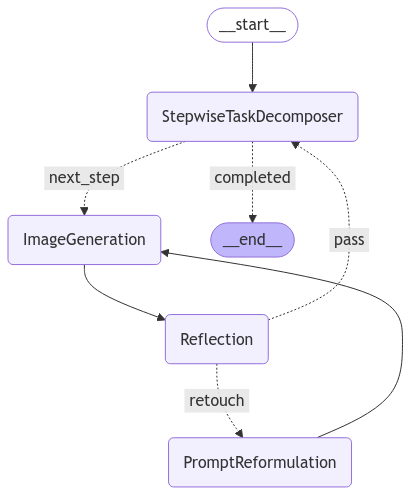

In [46]:
analyzer.show_graph()

In [34]:
#- Keep total steps between 1-3 depending on complexity

---StepwiseTaskDecomposer---
{
    "total_steps": 2,
    "steps": [
        {
            "step_number": 1,
            "description": "Establish the main subject, composition, and basic elements",
            "control_mode": "NONE",
            "control_strength": null,
            "prompt": {
                "positive": "A photo of a man with long black hair in a ponytail and a beard, wearing a red hat and dark suit, looking down at his cell phone with a smile on his face, captured in a natural pose",
                "negative": "multiple people, blurry, distorted features, missing limbs, extra limbs, deformed hands"
            }
        },
        {
            "step_number": 2,
            "description": "Refine facial details and expression",
            "control_mode": "SEGMENTATION",
            "control_strength": 0.7,
            "prompt": {
                "positive": "A photo of a man with a warm genuine smile, focused on his cell phone screen, with a neatly groomed beard a

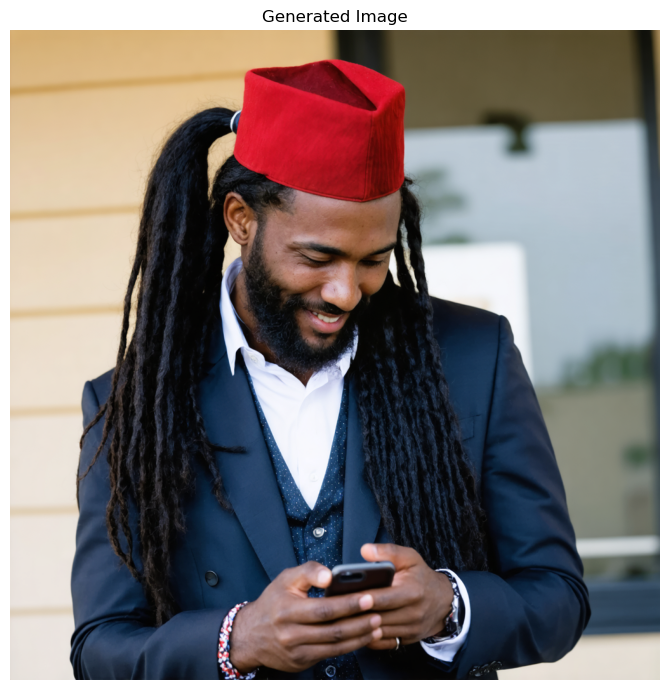

"\nOutput from node 'ImageGeneration':"
'---'
{ 'condition_image': './generated_imgs/GENERATED_IMAGE.png',
  'current_step': 1,
  'prev_node': 'ImageGeneration'}
'\n---\n'
---Reflection---
step_ask positive: A photo of a man with long black hair in a ponytail and a beard, wearing a red hat and dark suit, looking down at his cell phone with a smile on his face, captured in a natural pose, negative: multiple people, blurry, distorted features, missing limbs, extra limbs, deformed hands
{
    "retouch": "false",
    "suggestions": []
}---ShouldImageRegeneration---
"\nOutput from node 'Reflection':"
'---'
{ 'current_step': 2,
  'prev_node': 'Reflection',
  'retry_count': 0,
  'should_regeneration': 'pass',
  'suggestions': []}
'\n---\n'
---StepwiseTaskDecomposer---
---GO TO IMAGE GENERATION---
current_step:  2
---ShouldStepwiseImageGeneration---
"\nOutput from node 'StepwiseTaskDecomposer':"
'---'
{'prev_node': 'StepwiseTaskDecomposer'}
'\n---\n'
---ImageGeneration---
current_step 2
condit

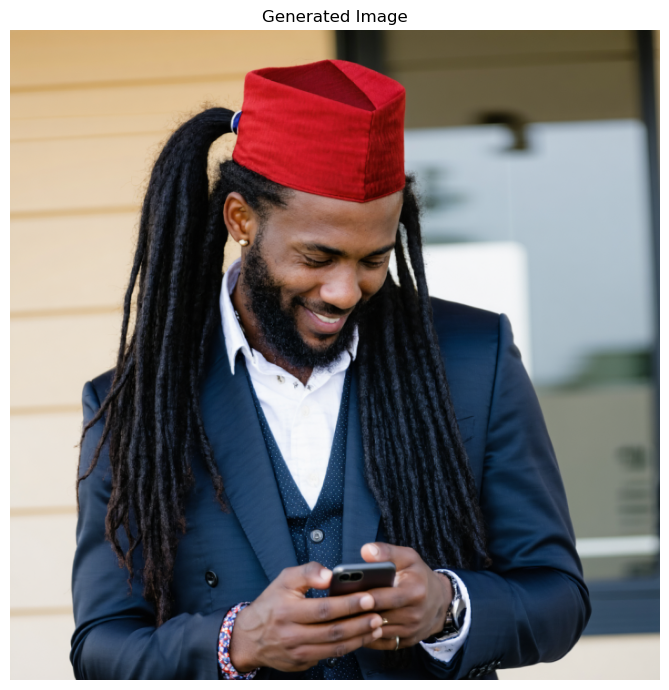

"\nOutput from node 'ImageGeneration':"
'---'
{ 'condition_image': './generated_imgs/GENERATED_IMAGE.png',
  'current_step': 2,
  'prev_node': 'ImageGeneration'}
'\n---\n'
---Reflection---
step_ask positive: A photo of a man with a warm genuine smile, focused on his cell phone screen, with a neatly groomed beard and long black hair tied back in a sleek ponytail, wearing a red hat, negative: multiple people, blurry, distorted features, missing limbs, extra limbs, deformed hands
{
    "retouch": "false",
    "suggestions": []
}---ShouldImageRegeneration---
"\nOutput from node 'Reflection':"
'---'
{ 'current_step': 3,
  'prev_node': 'Reflection',
  'retry_count': 0,
  'should_regeneration': 'pass',
  'suggestions': []}
'\n---\n'
---StepwiseTaskDecomposer---
---ShouldStepwiseImageGeneration---
"\nOutput from node 'StepwiseTaskDecomposer':"
'---'
{'prev_node': 'StepwiseTaskDecomposer'}
'\n---\n'


In [19]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

steps = analyzer.invoke(
    ask=dedent("A man with long black hair in a pony tail has a beard and is wearing a red hat and dark colored suit while he looks at his cell phone and is smiling."),
    image_model="nova-canvas"
)

In [ ]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

steps = analyzer.invoke(
    ask=dedent("Two white sheep on the left, a black goat on the middle and a white goat on the right in a field."),
    image_model="nova-canvas"
)

In [ ]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

steps = analyzer.invoke(
    ask=dedent("An oil painting, where a green vintage car, a blue scooter on the left of it and a black bicycle on the right of it, are parked on the road, with two birds in the sky."),
    image_model="nova-canvas"
)

In [ ]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

steps = analyzer.invoke(
    ask=dedent("늦은밤까지 aws 옷을 입고 샘플코드를 작성하고 있는 40대 남성. 책상엔 모니터가 2대가 있고, 주위는 어두우며 모니터 위에 스탠드 등이 켜져 있음. 시선은 모니터를 응시. 실제 사진"),
    image_model="nova-canvas"
)

---StepwiseTaskDecomposer---
{
    "total_steps": 3,
    "steps": [
        {
            "step_number": 1,
            "description": "Establish the core landscape composition with mountains, forest, lake, and volcano, ensuring proper spacing for the dragon and boats",
            "control_mode": "NONE",
            "control_strength": null,
            "prompt": {
                "positive": "A photo of a vast winter landscape, showing snow-covered mountain peaks stretching to the horizon, with a dense evergreen forest in the middle ground and a massive frozen lake in the foreground. An active volcano with smoke rising stands prominently near the lake, its dark form contrasting against the snowy peaks. The lake surface is smooth and reflective, with clear open areas for boats.",
                "negative": "people, boats, dragon, text, watermark, blurry, distorted, low quality, dark, oversaturated"
            }
        },
        {
            "step_number": 2,
            "descript

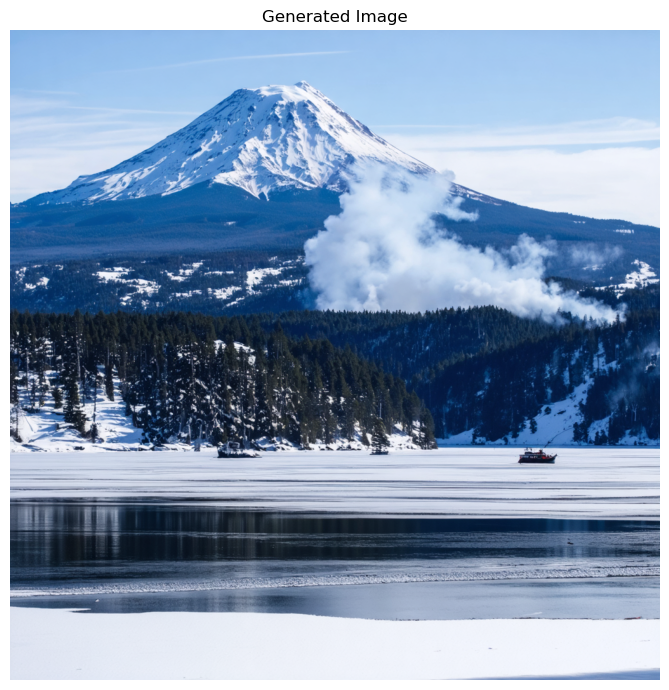

"\nOutput from node 'ImageGeneration':"
'---'
{ 'condition_image': './generated_imgs/GENERATED_IMAGE.png',
  'current_step': 1,
  'prev_node': 'ImageGeneration'}
'\n---\n'
---Reflection---
step_ask positive: A photo of a vast winter landscape, showing snow-covered mountain peaks stretching to the horizon, with a dense evergreen forest in the middle ground and a massive frozen lake in the foreground. An active volcano with smoke rising stands prominently near the lake, its dark form contrasting against the snowy peaks. The lake surface is smooth and reflective, with clear open areas for boats., negative: people, boats, dragon, text, watermark, blurry, distorted, low quality, dark, oversaturated
{
    "retouch": "false",
    "suggestions": []
}---ShouldImageRegeneration---
"\nOutput from node 'Reflection':"
'---'
{ 'current_step': 2,
  'prev_node': 'Reflection',
  'retry_count': 0,
  'should_regeneration': 'pass',
  'suggestions': []}
'\n---\n'
---StepwiseTaskDecomposer---
---GO TO IMAGE

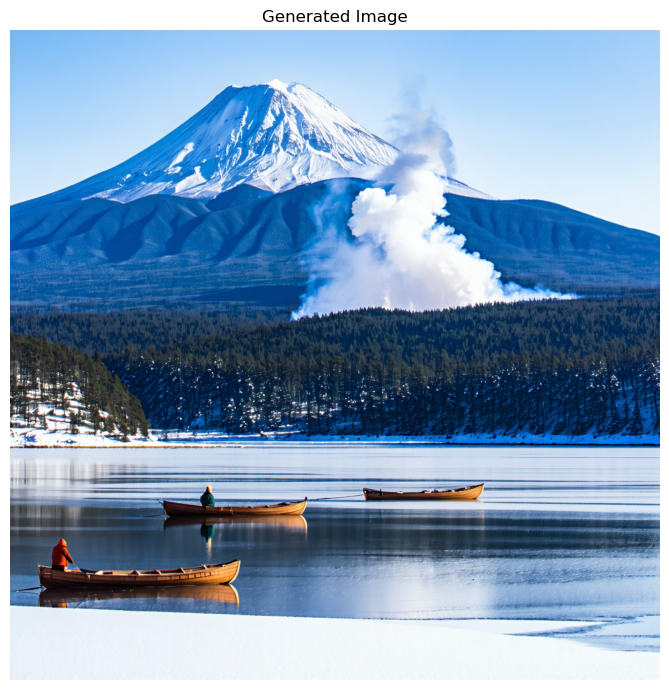

"\nOutput from node 'ImageGeneration':"
'---'
{ 'condition_image': './generated_imgs/GENERATED_IMAGE.png',
  'current_step': 2,
  'prev_node': 'ImageGeneration'}
'\n---\n'
---Reflection---
step_ask positive: A photo of a vast winter landscape with three small wooden boats scattered across the frozen lake, each carrying a single person bundled in winter clothing. Snow-covered mountain peaks stretch to the horizon, with a dense evergreen forest in the middle ground and the active volcano near the lake continuing to emit smoke., negative: dragon, crowds, multiple people in one boat, text, watermark, blurry, distorted, low quality, dark, oversaturated
{
    "retouch": "false",
    "suggestions": []
}---ShouldImageRegeneration---
"\nOutput from node 'Reflection':"
'---'
{ 'current_step': 3,
  'prev_node': 'Reflection',
  'retry_count': 0,
  'should_regeneration': 'pass',
  'suggestions': []}
'\n---\n'
---StepwiseTaskDecomposer---
---GO TO IMAGE GENERATION---
current_step:  3
---ShouldStepwi

ThrottlingException: An error occurred (ThrottlingException) when calling the InvokeModel operation: Too many requests, please wait before trying again.

In [50]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

steps = analyzer.invoke(
    ask=dedent(
        '''
        An icy landscape.
        A vast expanse of snow-covered mountain peaks stretches endlessly.
        Beneath them is a dense forest and a colossal frozen lake.
        Three people are boating in three boats separately in the lake.
        Not far from the lake, a volcano threatens eruption, its rumblings felt even from afar.
        Above, a ferocious red dragon dominates the sky and commands the heavens, fueled by the volcano's relentless energy flow.
        photorealistic, hyperrealistic, high definition, high resolution, highly detailed
        '''
    ),
    image_model="stable-diffusion"
)

---StepwiseTaskDecomposer---
{
    "total_steps": 2,
    "steps": [
        {
            "step_number": 1,
            "description": "Establish the main composition with the picnic table, hot dogs on plate, soda cup, bike, and car in their respective positions",
            "control_mode": "NONE",
            "control_strength": null,
            "prompt": {
                "positive": "A photo of two hot dogs on a green plate next to a soda cup, placed on a white picnic table. A red bicycle is parked on the left side, and a blue car is parked on the right side in the background",
                "negative": "blurry, distorted, low quality, unrealistic proportions, oversaturated"
            }
        },
        {
            "step_number": 2,
            "description": "Refine the details of the food items and vehicles",
            "control_mode": "SEGMENTATION",
            "control_strength": 0.7,
            "prompt": {
                "positive": "Two appetizing hot dogs with b

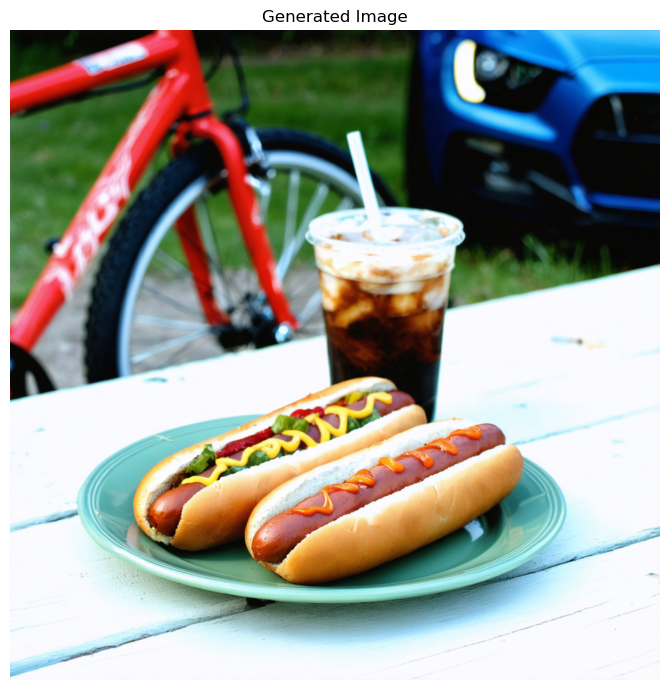

"\nOutput from node 'ImageGeneration':"
'---'
{ 'condition_image': './generated_imgs/GENERATED_IMAGE.png',
  'current_step': 1,
  'prev_node': 'ImageGeneration'}
'\n---\n'
---Reflection---
step_ask positive: A photo of two hot dogs on a green plate next to a soda cup, placed on a white picnic table. A red bicycle is parked on the left side, and a blue car is parked on the right side in the background, negative: blurry, distorted, low quality, unrealistic proportions, oversaturated
{
    "retouch": "false",
    "suggestions": []
}---ShouldImageRegeneration---
"\nOutput from node 'Reflection':"
'---'
{ 'current_step': 2,
  'prev_node': 'Reflection',
  'retry_count': 0,
  'should_regeneration': 'pass',
  'suggestions': []}
'\n---\n'
---StepwiseTaskDecomposer---
---GO TO IMAGE GENERATION---
current_step:  2
---ShouldStepwiseImageGeneration---
"\nOutput from node 'StepwiseTaskDecomposer':"
'---'
{'prev_node': 'StepwiseTaskDecomposer'}
'\n---\n'
---ImageGeneration---
current_step 2
condition

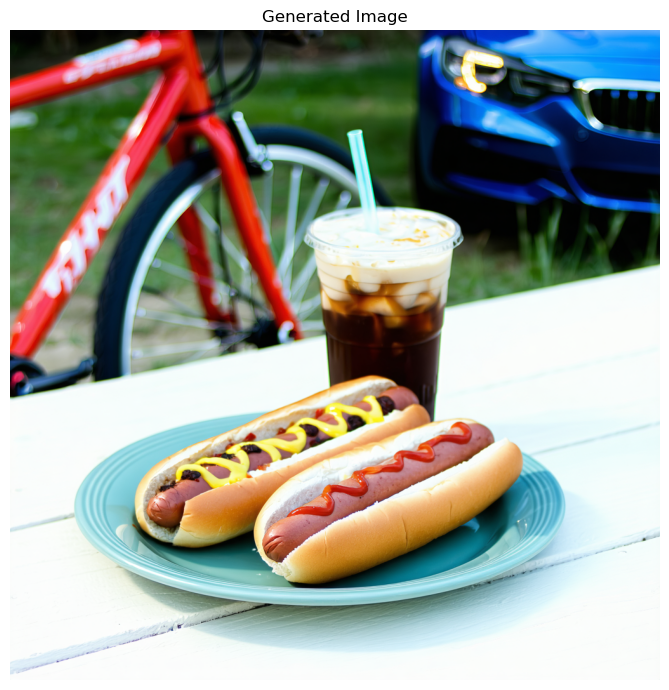

"\nOutput from node 'ImageGeneration':"
'---'
{ 'condition_image': './generated_imgs/GENERATED_IMAGE.png',
  'current_step': 2,
  'prev_node': 'ImageGeneration'}
'\n---\n'
---Reflection---
step_ask positive: Two appetizing hot dogs with buns on a bright green plate, a clear plastic soda cup with straw, sitting on a clean white picnic table. A shiny red bicycle with visible handlebars and wheels on the left, and a modern blue sedan car visible on the right side, negative: blurry, distorted, low quality, unrealistic proportions, oversaturated
{
    "retouch": "false",
    "suggestions": []
}---ShouldImageRegeneration---
"\nOutput from node 'Reflection':"
'---'
{ 'current_step': 3,
  'prev_node': 'Reflection',
  'retry_count': 0,
  'should_regeneration': 'pass',
  'suggestions': []}
'\n---\n'
---StepwiseTaskDecomposer---
---ShouldStepwiseImageGeneration---
"\nOutput from node 'StepwiseTaskDecomposer':"
'---'
{'prev_node': 'StepwiseTaskDecomposer'}
'\n---\n'


In [36]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)
steps = analyzer.invoke(
    ask=dedent(
        '''
        Two hot dogs sit on a green plate near a soda cup which are sitting on a white picnic table, while a red bike (on the left of image) and a blue car (on the right of image)are parked nearby.
        A high-resolution DSLR photograph
        '''
    ),
    image_model="stable-diffusion"
)

---StepwiseTaskDecomposer---
{
    "total_steps": 2,
    "steps": [
        {
            "step_number": 1,
            "description": "Establish the basic composition with three boys standing side by side in the rain, with their distinct clothing colors",
            "control_mode": "NONE",
            "control_strength": null,
            "prompt": {
                "positive": "A photo of three boys standing side by side in the rain. From left to right: first boy wearing a green shirt and blue shorts, second boy wearing a red shirt and black shorts, third boy wearing a white shirt and yellow shorts. Rain falling in the scene, creating a gentle atmosphere",
                "negative": "umbrella, raincoat, dark lighting, blurry, oversaturated colors, distorted proportions"
            }
        },
        {
            "step_number": 2,
            "description": "Enhance the rain effect and clothing details",
            "control_mode": "SEGMENTATION",
            "control_strength":

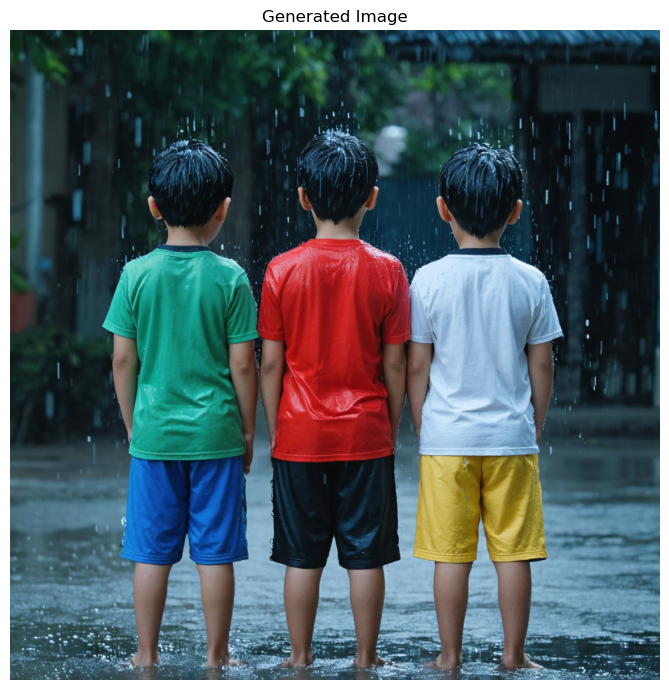

"\nOutput from node 'ImageGeneration':"
'---'
{ 'condition_image': './generated_imgs/GENERATED_IMAGE.png',
  'current_step': 1,
  'prev_node': 'ImageGeneration'}
'\n---\n'
---Reflection---
step_ask positive: A photo of three boys standing side by side in the rain. From left to right: first boy wearing a green shirt and blue shorts, second boy wearing a red shirt and black shorts, third boy wearing a white shirt and yellow shorts. Rain falling in the scene, creating a gentle atmosphere, negative: umbrella, raincoat, dark lighting, blurry, oversaturated colors, distorted proportions
{
    "retouch": "false",
    "suggestions": []
}---ShouldImageRegeneration---
"\nOutput from node 'Reflection':"
'---'
{ 'current_step': 2,
  'prev_node': 'Reflection',
  'retry_count': 0,
  'should_regeneration': 'pass',
  'suggestions': []}
'\n---\n'
---StepwiseTaskDecomposer---
---GO TO IMAGE GENERATION---
current_step:  2
---ShouldStepwiseImageGeneration---
"\nOutput from node 'StepwiseTaskDecomposer':"


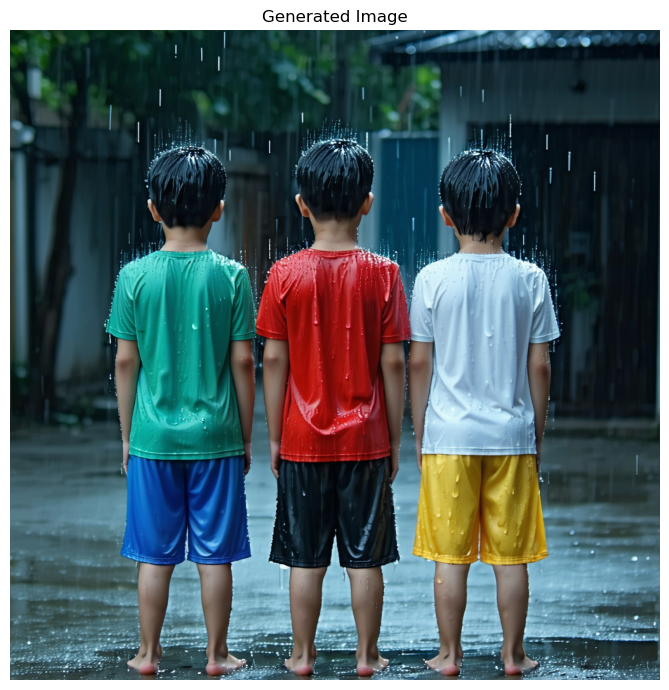

"\nOutput from node 'ImageGeneration':"
'---'
{ 'condition_image': './generated_imgs/GENERATED_IMAGE.png',
  'current_step': 2,
  'prev_node': 'ImageGeneration'}
'\n---\n'
---Reflection---
step_ask positive: Rain droplets visible in the air, wet clothing showing rain effects. From left to right: first boy's green shirt and blue shorts slightly wet, second boy's red shirt and black shorts with rain drops, third boy's white shirt and yellow shorts showing dampness from the rain, negative: umbrella, raincoat, dark lighting, blurry, oversaturated colors, distorted proportions
{
    "retouch": "false",
    "suggestions": []
}---ShouldImageRegeneration---
"\nOutput from node 'Reflection':"
'---'
{ 'current_step': 3,
  'prev_node': 'Reflection',
  'retry_count': 0,
  'should_regeneration': 'pass',
  'suggestions': []}
'\n---\n'
---StepwiseTaskDecomposer---
---ShouldStepwiseImageGeneration---
"\nOutput from node 'StepwiseTaskDecomposer':"
'---'
{'prev_node': 'StepwiseTaskDecomposer'}
'\n---\n'

In [37]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)
steps = analyzer.invoke(
    ask=dedent(
        '''
        Three boys in green, red, white shirts and blue, black, yellow short pants separately from left to right, are in the rain.
        
        '''
    ),
    image_model="stable-diffusion"
)

In [ ]:
wo blue hardcover
books on the left
of a rectangular
table, with two red
chairs on the right
and one black couch
on the behind.

In [ ]:
steps = analyzer.invoke(
    ask=dedent('Five cars on the street'),
    image_model="nova-canvas",
    reset=False
)

In [ ]:
steps = analyzer.invoke(
    ask=dedent("An icy landscape. A vast expanse of snow-covered mountain peaks stretches endlessly. Beneath them is a dense forest and a colossal frozen lake. Three people are boating in three boats separately in the lake. Not far from the lake, a volcano threatens eruption, its rumblings felt even from afar. Above, a ferocious red dragon dominates the sky and commands the heavens, fueled by the volcano's relentless energy flow. photorealistic, hyperrealistic, high definition, high resolution, highly detailed"),
    image_model="nova-canvas",
    reset=True
)

In [ ]:
import io
import json
import base64
import random
import matplotlib.pyplot as plt

In [ ]:
def _png_to_bytes(file_path):
    try:
        with open(file_path, "rb") as image_file:
            # 파일을 바이너리 모드로 읽기
            binary_data = image_file.read()

            # 바이너리 데이터를 base64로 인코딩
            base64_encoded = base64.b64encode(binary_data)

            # bytes 타입을 문자열로 디코딩
            base64_string = base64_encoded.decode('utf-8')

            return binary_data, base64_string

    except FileNotFoundError:
        return "Error: 파일을 찾을 수 없습니다."
    except Exception as e:
        return f"Error: {str(e)}"

def _img_generation_and_show(image_generation_model, body, original_image_path, mask_image_path=None):
    # 원본 이미지 로드
    original_image = Image.open(original_image_path)
    
    # 생성된 이미지 얻기
    response = image_generation_model.bedrock_client.invoke_model(
        body=body,
        modelId=image_generation_model.model_id
    )
    response_body = json.loads(response.get("body").read())
    base64_image = response_body.get("images")[0]
    image_data = base64.b64decode(base64_image)
    generated_image = Image.open(io.BytesIO(image_data))
    
    # mask_image_path의 유무에 따라 subplot 개수 조정
    if mask_image_path:
        # 마스크 이미지가 있는 경우 3개의 subplot 생성
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
        
        # 원본 이미지 표시
        ax1.imshow(original_image)
        ax1.axis('off')
        ax1.set_title('Original Image')
        
        # 마스크 이미지 표시
        mask_image = Image.open(mask_image_path)
        ax2.imshow(mask_image)
        ax2.axis('off')
        ax2.set_title('Mask Image')
        
        # 생성된 이미지 표시
        ax3.imshow(generated_image)
        ax3.axis('off')
        ax3.set_title('Generated Image')
    else:
        # 마스크 이미지가 없는 경우 2개의 subplot 생성
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        
        # 원본 이미지 표시
        ax1.imshow(original_image)
        ax1.axis('off')
        ax1.set_title('Original Image')
        
        # 생성된 이미지 표시
        ax2.imshow(generated_image)
        ax2.axis('off')
        ax2.set_title('Generated Image')

    # save images
    img_path = './generated_imgs/GENERATED_IMAGE_TEST.png'
    generated_image.save(img_path, "PNG")
    
    plt.tight_layout()  # 레이아웃 조정
    plt.show()


In [ ]:
steps["steps"][0]

In [ ]:
origin_img_path = "./generated_imgs/GENERATED_IMAGE_TEST.png"
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            'text': steps["steps"][0]["prompt"]["positive"],
            "negativeText": steps["steps"][0]["prompt"]["negative"],
            #"conditionImage": origin_img_base64,
            #"controlMode": "SEGMENTATION", # "CANNY_EDGE" | "SEGMENTATION", 
            #"controlStrength": 0.5 # 0 to 1.0
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 1024,
            "width": 1024,
            "cfgScale": 8.0,
            "seed": 8, #random.randint(0, 100000)
            "quality": "premium" #"standard" | "premium",
        }
    }
)
_img_generation_and_show(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path
)

In [ ]:
steps["steps"][1]

In [ ]:
origin_img_path = "./generated_imgs/GENERATED_IMAGE_TEST.png"
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            'text': steps["steps"][1]["prompt"]["positive"],
            "negativeText": steps["steps"][1]["prompt"]["negative"],
            "conditionImage": origin_img_base64,
            "controlMode": steps["steps"][1]["control_mode"].upper(),
            "controlStrength": steps["steps"][1]["control_strength"]
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 1024,
            "width": 1024,
            "cfgScale": 8.0,
            "seed": 8, #random.randint(0, 100000)
            "quality": "premium" #"standard" | "premium",
        }
    }
)

_img_generation_and_show(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path
)

In [ ]:
steps["steps"][2]

In [ ]:
origin_img_path = "./generated_imgs/GENERATED_IMAGE_TEST.png"
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            'text': steps["steps"][2]["prompt"]["positive"],
            "negativeText": steps["steps"][2]["prompt"]["negative"],
            "conditionImage": origin_img_base64,
            "controlMode": steps["steps"][2]["control_mode"].upper(),
            "controlStrength": steps["steps"][2]["control_strength"]
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 1024,
            "width": 1024,
            "cfgScale": 8.0,
            "seed": 8, #random.randint(0, 100000)
            "quality": "premium" #"standard" | "premium",
        }
    }
)

_img_generation_and_show(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path
)

In [ ]:
steps["steps"][3]

In [ ]:
origin_img_path = "./generated_imgs/GENERATED_IMAGE_TEST.png"
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            'text': steps["steps"][3]["prompt"]["positive"],
            "negativeText": steps["steps"][3]["prompt"]["negative"],
            "conditionImage": origin_img_base64,
            "controlMode": steps["steps"][3]["control_mode"].upper(),
            "controlStrength": steps["steps"][3]["control_strength"]
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 1024,
            "width": 1024,
            "cfgScale": 8.0,
            "seed": 8, #random.randint(0, 100000)
            "quality": "premium" #"standard" | "premium",
        }
    }
)

_img_generation_and_show(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path
)

In [ ]:
origin_img_path = "./generated_imgs/GENERATED_IMAGE_TEST-2.png"
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            'text': 'A restroom features black and white checkered flooring, two toilets of which has a black seat and lid and the other a white seat and lid, two black sinks.',
            #"negativeText": steps["steps"][3]["prompt"]["negative"],
            #"conditionImage": origin_img_base64,
            #"controlMode": steps["steps"][3]["control_mode"].upper(),
            #"controlStrength": steps["steps"][3]["control_strength"]
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 1024,
            "width": 1024,
            "cfgScale": 8.0,
            "seed": 230, #random.randint(0, 100000)
            "quality": "premium" #"standard" | "premium",
        }
    }
)

_img_generation_and_show(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path
)

In [ ]:

analyzer.invoke(
    ask=dedent("용을 산 꼭대기에 위치하도록 해줘"),
    image_model="nova-canvas"
)

In [ ]:
analyzer.invoke(
    ask=dedent("용이 화산이 발생하는 산 꼭대기에서 마치 화산에서 튀어 나오는 것 처럼 해줘"),
    image_model="nova-canvas"
)

In [ ]:
analyzer.invoke(
    ask=dedent("전체 몸이 다 보이도록 변경해줘"),
    image_model="nova-canvas"
)

In [ ]:
analyzer.invoke(
    ask=dedent("high-end camera, shot on Canon EOS R5, 스튜디오 촬영, photorealistic, 한 남성 모델이 세탁기 옆에서 세탁기 광고를 촬영하는 모습"),
    image_model="nova-canvas"
)

In [ ]:
analyzer.invoke(
    ask=dedent("창밖에서 따듯한 햇살이 비추는 오전, 커피 한잔을 미술용 테이블에 올려놓고, 오늘은 어떤 하루를 보낼지 생각하는 우아하고 예쁜 동양인 여성 미술 원장, realistic editorial photo"),
    image_model="nova-canvas"
)

In [ ]:
bb

In [ ]:
analyzer.invoke(
    ask=dedent("사람이 창문을 보고 서 있는 모습으로 변경해줘"),
    image_model="nova-canvas"
)

In [ ]:
analyzer.invoke(
    ask=dedent("여성이 서있지 않고 앉아있는 자세로 촬영되어 있어 'standing'과 차이 가 있습니다. 이 부분을 수정해서 생성해 주세요"),
    image_model="nova-canvas"
)

In [ ]:
analyzer.invoke(
    ask=dedent("벽면의 아트워크와 디자인 요소들이 이미지에서 보이지 않으므로 벽면 장식을 추가하면 좋겠습니다"),
    image_model="nova-canvas"
)

In [ ]:
 def _get_message_from_string(role, string, imgs=None):
        
    message = {
        "role": role,
        "content": []
    }

    if imgs is not None:
        for img in imgs:
            img_message = {
                "image": {
                    "format": 'png',
                    "source": {"bytes": img}
                }
            }
            message["content"].append(img_message)

    message["content"].append({"text": dedent(string)})

    return message

def _png_to_bytes( file_path):
    try:
        with open(file_path, "rb") as image_file:
            # 파일을 바이너리 모드로 읽기
            binary_data = image_file.read()

            # 바이너리 데이터를 base64로 인코딩
            base64_encoded = base64.b64encode(binary_data)

            # bytes 타입을 문자열로 디코딩
            base64_string = base64_encoded.decode('utf-8')

            return binary_data, base64_string

    except FileNotFoundError:
        return "Error: 파일을 찾을 수 없습니다."
    except Exception as e:
        return f"Error: {str(e)}"

In [ ]:
#img_path = state["img_path"] # PNG 파일 경로
img_path = "./generated_imgs/GENERATED_IMAGE.png"
messages = []  
llm_caller = llm_call(
    llm=llm,
    verbose=False
)
ask_reformulation = "어두운 하늘의 구름을 그려줘"

system_prompts = dedent(
    '''
    <task>
    이미지 생성 요청과 생성된 이미지 간의 부합도를 평가하는 에이전트 역할 수행
    </task>

    <instruction>
    1. 사용자의 이미지 생성 요청을 다음 기준으로 분석하세요:
       - 요청된 주요 객체나 대상
       - 구체적인 시각적 특성 (색상, 크기, 형태 등)
       - 구도나 배치에 대한 요구사항
       - 스타일이나 분위기에 대한 설명
       - 특수한 효과나 기법에 대한 요청

    2. 생성된 이미지를 다음 측면에서 평가하세요:
       - 요청된 주요 객체의 존재 여부와 정확성
       - 시각적 특성의 구현 정도
       - 구도와 배치의 일치도
       - 전반적인 스타일과 분위기의 부합성
       - 특수 효과나 기법의 적용 상태

    3. 평가 결과를 수치화하여 다음 항목별로 점수를 매기세요:
       - 객체 정확도 (0-20점)
       - 시각적 특성 구현도 (0-20점)
       - 구도/배치 일치도 (0-20점)
       - 스타일/분위기 부합도 (0-20점)
       - 전반적 완성도 (0-20점)
    4. DO NOT use ```json``` in response.
    </instruction>

    <scoring_criteria>
    - 객체 정확도 (20점)
      * 20점: 모든 요청 객체가 정확히 표현됨
      * 15점: 주요 객체는 있으나 일부 세부사항 누락
      * 10점: 일부 주요 객체 누락 또는 부정확
      * 5점: 대부분의 객체가 부정확하거나 누락
      * 0점: 요청 객체와 전혀 다른 내용

    - 시각적 특성 구현도 (20점)
      * 20점: 모든 시각적 특성이 정확히 구현됨
      * 15점: 대부분의 특성이 구현되었으나 일부 미흡
      * 10점: 주요 특성만 부분적으로 구현
      * 5점: 대부분의 특성이 미구현
      * 0점: 요청된 특성과 전혀 다름

    - 구도/배치 일치도 (20점)
      * 20점: 요청된 구도와 완벽히 일치
      * 15점: 전반적 구도는 유사하나 일부 차이
      * 10점: 기본적인 구도만 일치
      * 5점: 구도가 크게 다름
      * 0점: 전혀 다른 구도

    - 스타일/분위기 부합도 (20점)
      * 20점: 의도된 스타일과 분위기를 완벽히 구현
      * 15점: 유사한 스타일과 분위기 표현
      * 10점: 부분적으로만 의도된 분위기 표현
      * 5점: 의도와 다른 분위기
      * 0점: 전혀 다른 스타일과 분위기

    - 전반적 완성도 (20점)
      * 20점: 전문적 수준의 완성도
      * 15점: 양호한 완성도
      * 10점: 기본적인 완성도
      * 5점: 미흡한 완성도
      * 0점: 매우 낮은 완성도
    </scoring_criteria>

    <output_format>
     JSON 형식으로 다음 정보를 포함하여 응답하세요. 절대 JSON 포멧 외 텍스트는 넣지 마세요.:
    {{
       "score": "일치도 스코어",
       "suggestions": "사용자 요청에 더욱 부합하기 위해 개선해야 할 사항"
    }}
    </output_format>

    <considerations>
    - 요청 사항이 모호한 경우, 일반적인 기준에서 합리적으로 해석하여 평가합니다.
    - 기술적 제약으로 인한 한계는 감안하여 평가합니다.
    - 주관적 요소(예: 분위기, 감정)는 일반적인 인식을 기준으로 평가합니다.
    - 평가는 건설적이고 객관적인 관점에서 이루어져야 합니다.
    - 개선점은 구체적이고 실행 가능한 제안으로 제시합니다.
    </considerations>

    <restrictions>
    - 개인적인 취향이나 선호도에 기반한 평가는 지양합니다.
    - 비윤리적이거나 부적절한 내용에 대한 평가는 거부합니다.
    - 기술적으로 구현 불가능한 요소에 대해서는 감점하지 않습니다.
    - 저작권이나 윤리적 문제가 있는 요청에 대해서는 평가를 중단합니다.
    </restrictions>

    이 프롬프트는 이미지 생성 요청과 실제 생성된 이미지 간의 일치도를 체계적이고 객관적으로 평가할 수 있도록 구성되었습니다.
    각 평가 항목에 대한 명확한 기준을 제시하고, 정량적인 점수와 정성적인 평가를 함께 제공하여 종합적인 평가가 가능하도록 했습니다.
    '''
 )

system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

user_prompts = dedent(
    '''
    Here is the question: <ask>{ask}</ask>
    '''
)

context = {
    "ask": ask_reformulation
}
user_prompts = user_prompts.format(**context)

img_bytes, img_base64 = _png_to_bytes(img_path)
message = _get_message_from_string(role="user", string=user_prompts, imgs=[img_bytes])
messages.append(message)

resp, messages_updated = llm_caller.invoke(messages=messages, system_prompts=system_prompts)

In [48]:
#기존 파일

In [ ]:
class genai_analyzer():

    def __init__(self, **kwargs):

        self.llm=kwargs["llm"]
        self.image_generation_model = kwargs["image_generation_model"]
        self.state = GraphState

        self.llm_caller = llm_call(
            llm=self.llm,
            verbose=False
        ) 

        self._graph_definition()
        self.messages = []

        self.timer = TimeMeasurement()

    def _get_string_from_message(self, message):
        return message["content"][0]["text"]

    def _get_message_from_string(self, role, string, imgs=None):
        
        message = {
            "role": role,
            "content": []
        }
        
        if imgs is not None:
            for img in imgs:
                img_message = {
                    "image": {
                        "format": 'png',
                        "source": {"bytes": img}
                    }
                }
                message["content"].append(img_message)
        
        message["content"].append({"text": dedent(string)})

        return message
    
    def _png_to_bytes(self, file_path):
        try:
            with open(file_path, "rb") as image_file:
                # 파일을 바이너리 모드로 읽기
                binary_data = image_file.read()
                
                # 바이너리 데이터를 base64로 인코딩
                base64_encoded = base64.b64encode(binary_data)
                
                # bytes 타입을 문자열로 디코딩
                base64_string = base64_encoded.decode('utf-8')
                
                return binary_data, base64_string
                
        except FileNotFoundError:
            return "Error: 파일을 찾을 수 없습니다."
        except Exception as e:
            return f"Error: {str(e)}"

    def show_save_image(self, base64_string):
        try:
            
            # base64 문자열을 디코딩하여 바이너리 데이터로 변환
            image_data = base64.b64decode(base64_string)
            
            # 바이너리 데이터를 이미지로 변환
            image = Image.open(io.BytesIO(image_data))

            fig, (ax1) = plt.subplots(1, 1, figsize=(15, 7))
            ax1.imshow(image)
            ax1.axis('off')
            ax1.set_title('Generated Image')

            plt.tight_layout()  # 레이아웃 조정
            plt.show()
            
            # save images
            img_path = './generated_imgs/GENERATED_IMAGE.png'
            image.save(img_path, "PNG")
            
            return img_path
            
        except Exception as e:
            print(f"Error: 이미지를 표시하는 데 실패했습니다. {str(e)}")
            
    def _body_generator(self, pos_prompt, neg_prompt="", condition_image=None, control_strength=None, seed=1):
    
        if condition_image == None:
            self.image_generation_model.model_id = "stability.stable-image-ultra-v1:1"
            print (f'Image generator: SD-Ultra')
            body_dict = {
                "prompt": pos_prompt,
                "negative_prompt": neg_prompt,
                "mode": "text-to-image",
                "aspect_ratio": "1:1",  # Default 1:1. Enum: 16:9, 1:1, 21:9, 2:3, 3:2, 4:5, 5:4, 9:16, 9:21.
                "output_format": "png",
                "seed": seed
            }
        else:
            self.image_generation_model.model_id = "stability.sd3-5-large-v1:0"
            print (f'Image generator: SD-3-5-Large')
            body_dict = {
                "prompt": pos_prompt,
                "negative_prompt": neg_prompt,
                "mode": "image-to-image",
                "strength": (1-control_strength), # nova랑 반대
                "image": condition_image,
                "output_format": "png",
                "seed": seed
            }

        return json.dumps(body_dict)

    def get_messages(self, ):
        return self.messages
        
    def _graph_definition(self, **kwargs):

        def StepwiseTaskDecomposer(state):

            self.timer.start()
            self.timer.reset()
            
            print("---StepwiseTaskDecomposer---")
            ask = state["ask"]
            current_step = state.get("current_step", 1)
            messages = []
        
            system_prompts = dedent(
                
                '''
                You are an agent that plans steps for stepwise image generation based on user requests. Your role is to:

                1. Break down the user's request into manageable steps, considering:
                   - Each step's output should maintain consistency with the previous step's image
                   - Only segmentation control mode is available from step 2 onwards
                   - Start with basic composition and layout, then gradually add details
                   - Set appropriate control strength for each step to ensure smooth transitions
                
                2. For each step, you should provide:
                   - Step description
                   - Selected control mode (NONE for step 1, SEGMENTATION for subsequent steps)
                   - Control strength (0.0-1.0, not applicable for step 1)
                   - Image generation prompt that:
                     * Maintains key elements from previous steps
                     * Clearly specifies what new elements/details to add
                     * Uses image captioning style (e.g., "A photo of X, showing Y, with Z in the background")
                     * Uses appropriate style and composition keywords for consistency                
                
                Guidelines for planning steps:
                
                1. First Step (Crucial Composition and Subject Stage):
                   - No control mode is available (use "NONE" or "UNCONDITIONAL")
                   - Control strength should be null or 0 (not applicable)
                   - First Step is Critical:
                     * This step determines the final composition
                     * Later steps cannot significantly change the layout
                     * Must consider space for all future elements
                   - Critical for establishing overall scene composition AND main subjects:
                     * Include ALL major elements that affect scene layout
                     * Include primary subjects with appropriate emphasis and scale
                     * Set up primary spatial relationships and viewpoint
                     * Consider foreground/background structure
                     * Plan for elements that require specific positioning
                   - Elements requiring first-step inclusion:
                     * Primary subjects (must be prominently featured)
                     * Multiple objects with specific spatial relationships
                     * Elements requiring particular viewing angles
                     * Background elements that affect overall composition
                   - Composition priorities:
                     * Consider the full scene, not just current elements
                     * Ensure primary subjects are prominently sized and positioned
                     * Maintain appropriate scale relationships between elements
                     * Create clear visual hierarchy emphasizing main subjects
                   - Provide comprehensive prompt prioritizing subject emphasis
                   - This will serve as the foundational layout for subsequent refinements
                   
                2. Last Steps (From Step 2 onwards):
                   - Use segmentation control mode for adding or modifying objects
                   - Control strength guidelines:
                     * For major new elements: 0.4-0.5 (allows significant changes while maintaining basic structure)
                     * For moderate additions: 0.5-0.7 (balanced flexibility for new elements)
                     * For minor modifications: 0.7-0.9 (strongly preserves existing elements)
                   - Each prompt should explicitly reference maintaining previous elements
                   - Add new elements gradually, not all at once
                   - Consider the scale and impact of new elements when selecting control strength
                   - Style Consistency Guidelines:
                     * DO NOT include style-related keywords:
                       - Remove quality enhancers (photorealistic, hyperrealistic, etc.)
                       - Remove resolution indicators (HD, 8K, etc.)
                       - Remove lighting descriptors (dramatic, cinematic, etc.)
                       - Focus only on describing desired changes and additions
                
                Control Strength Guidelines:
                - Not applicable for Step 1
                - 0.4-0.5: For major compositional changes only
                - 0.5-0.6: For significant detail additions while maintaining realism
                - 0.6-0.7: For moderate refinements and enhancements
                - 0.7-0.8: For subtle adjustments
                - 0.8-0.9: For final refinements while maintaining photorealism
                - Above 0.9: Not recommended as it may result in over-processed appearance
                
                Composition Planning Strategy:
                1. Subject and Layout Analysis:
                   - Identify primary subjects from user request
                   - Analyze the request for elements that affect overall layout
                   - Determine required scale and emphasis of main subjects
                   - Plan which elements must be included in first step
                   - Consider how later additions might interact with initial composition
                
                2. Elements to Include in First Step:
                   - Primary subjects that need prominent emphasis
                   - Major background elements (buildings, landscapes, etc.)
                   - Objects requiring specific spatial relationships
                   - Elements that define the viewing angle or perspective
                   - Any items that other elements will need to be positioned relative to
                
                3. Subject Emphasis Guidelines:
                   - Position primary subjects in visually dominant locations
                   - Ensure appropriate size and scale for main subjects
                   - Use composition techniques to draw attention to key elements:
                     * Foreground placement for emphasis
                     * Contrasting sizes between primary and secondary elements
                     * Clear separation from background elements
                   - Consider viewing angle that best showcases primary subjects
                
                4. Elements Suitable for Later Steps:
                   - Additional details that follow established composition
                   - Secondary objects that complement main subjects
                   - Composition and lighting enhancements
                   - Elements that don't require major compositional changes
                
                Scene Composition Guidelines:
                1. Foreground vs Background:
                   - When adding background elements:
                     * Use lower control strength (0.4-0.5)
                     * Place background description early in the prompt
                     * Be specific about spatial relationships
                     * Example: "A photo showing a blue sedan car in the background, with [foreground elements] in the foreground"
                   - When modifying foreground elements:
                     * Use higher control strength (0.6-0.8)
                     * Focus on maintaining clear separation between fore/background
                     * Be explicit about layering and depth
                
                2. Spatial Relationships:
                   - Always specify clear positions (left, right, background, foreground)
                   - Use distance indicators (near, far, closer to, behind)
                   - Consider depth and perspective in the scene
                   - Example: "A blue sedan parked in the far background, with a picnic table in the near foreground"
                
                Special Cases for Major Elements:
                1. When adding completely new, large, or dominant elements:
                   - Use lower control strength (0.4-0.5)
                   - Place the new element at the beginning of the prompt
                   - Provide detailed descriptions of the new element
                   - Consider the element's role in overall composition (foreground/background)
                   - Example: "A photo of a massive red dragon in the sky" instead of "A landscape with a dragon"
                
                2. For challenging elements (creatures, vehicles, dramatic effects):
                   - Be more specific about characteristics (size, color, texture)
                   - Add relevant style emphasizers (realistic, detailed, majestic)
                   - Consider breaking the addition into sub-steps if needed
                   - Avoid burying important new elements in the middle of the prompt
                   - Be explicit about viewing angle and perspective
                
                Required Output Format:
                DO NOT include any text outside the JSON format in the response
                You must provide your response in the following JSON format:
                {
                    "total_steps": <number_of_steps>,
                    "steps": [
                        {
                            "step_number": <number>,
                            "description": <string>,
                            "control_mode": <"NONE" for step 1, "SEGMENTATION" for others>,
                            "control_strength": <null/0 for step 1, float for others>,
                            "prompt": {
                                "positive": <string>,
                                "negative": <string>
                            },
                        },
                        ...
                    ],
                }
                
                Prompt Writing Guidelines:
                - Use image captioning style for all prompts
                - Start with "A photo of" or similar natural description
                - When adding major new elements:
                  * Place them at the start of the prompt
                  * Provide detailed, specific descriptions
                  * Example: "A photo of a massive red dragon with glowing scales" vs "A photo of mountains with a dragon"
                - When establishing scene composition:
                  * Clearly state spatial relationships
                  * Use depth indicators (foreground, background, near, far)
                  * Specify viewing angles when relevant
                - Describe main subjects first, then background/details
                - Use clear spatial relationships (in the foreground, background, left, right, etc.)
                - Use Stable Diffusion-optimized keywords and structure
                - Keep the total prompt length under 10,000 characters
                - Write prompts as concisely as possible
                - Include relevant style keywords at the end of the description
                - For challenging or complex elements:
                  * Be extremely specific about characteristics
                  * Use multiple descriptive adjectives
                  * Consider adding emphasis words (majestic, dramatic, powerful)
                  * Include relevant technical details when appropriate
                
                Remember:
                - First step is unconditional (no control mode or strength)
                - Minimize the number of steps (1-2 maximum) and prefer fewer steps when possible
                - Ensure each step builds naturally upon the previous one
                - Pay special attention to foreground/background relationships
                - Be specific about spatial relationships and compositions
                - Select control strength values that ensure smooth transitions between steps
                - Use appropriate quality enhancers without overdoing it
                - Maintain consistent style across all steps by:
                    - Using the same artistic style keywords in each step
                    - Keeping consistent quality enhancers throughout
                    - Maintaining similar lighting and atmosphere descriptions
                    - Using consistent camera/perspective terms
                    - Applying the same level of detail in descriptions
                    - Using matching rendering style indicators (e.g., "realistic", "artistic", "photographic")
                
                '''
            )

            if current_step == 1:
                system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
                user_prompts = dedent(
                    '''
                    Here is user's ask: <ask>{ask}</ask>
                    '''
                )
                context = {
                    "ask": ask,
                }
                user_prompts = user_prompts.format(**context)
                           
                message = self._get_message_from_string(role="user", string=user_prompts)
                self.messages.append(message)
                messages.append(message)
                
                resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
                self.messages.append(ai_message)
                            
                results = json.loads(resp['text'])
                total_steps, steps = results["total_steps"], results["steps"]
                should_next_step = "next_step"
            
                return self.state(
                    total_steps=total_steps,
                    steps=steps,
                    should_next_step=should_next_step,
                    prev_node="StepwiseTaskDecomposer"
                )
            else:
                generation_steps = state["steps"]
                if current_step <= len(generation_steps):
                    print ("---GO TO IMAGE GENERATION---")
                    print ("current_step: ", current_step)
                    should_next_step = "next_step"
                else:
                    should_next_step = "completed"
                    
                return self.state(
                    should_next_step=should_next_step,
                    prev_node="StepwiseTaskDecomposer"
                )
            
            
        def ShouldStepwiseImageGeneration(state):

            print("---ShouldStepwiseImageGeneration---")
            return state["should_next_step"]

        def ImageGeneration(state):
            
            print("---ImageGeneration---")
            generation_steps, current_step = state["steps"], state.get("current_step", 1)
            condition_image = state.get("condition_image", None)
            seed = state.get("seed", 1)
            prev_node = state.get("prev_node", None)
            
            pos_prompt = generation_steps[current_step-1]["prompt"]["positive"]
            neg_prompt = generation_steps[current_step-1]["prompt"]["negative"]
            control_mode = generation_steps[current_step-1]["control_mode"].upper()
            control_strength = generation_steps[current_step-1]["control_strength"]
            if prev_node == "PromptReformulation": seed = random.randint(0, 100000)


            print ("current_step", current_step)
            print ("condition_image", condition_image)
            print ("prev_node", prev_node)
            print ("seed", seed)
                      
            if condition_image is not None and current_step != 1:
                img_bytes, img_base64 = self._png_to_bytes(condition_image)
                condition_image = img_base64
            else:
                condition_image = None
            
            body = self._body_generator(
                pos_prompt=pos_prompt,
                neg_prompt=neg_prompt,
                condition_image=condition_image,
                control_strength=control_strength, # nova랑 반대
                seed=seed
            )
            
            response = self.image_generation_model.bedrock_client.invoke_model(
                body=body,
                modelId=self.image_generation_model.model_id
            )
            response_body = json.loads(response.get("body").read())
            base64_image = response_body.get("images")[0]
            condition_image = self.show_save_image(base64_image)
            
            return self.state(
                condition_image=condition_image,
                current_step=current_step,
                prev_node="ImageGeneration"
            )
        
        def PromptReformulation(state):
            
            print("---PromptReformulation---")
            generation_steps = state["steps"]
            suggestions = state["suggestions"]
            current_step = state["current_step"]
            retry_count = state.get("retry_count", 0)

            pos_prompt = generation_steps[current_step-1]["prompt"]["positive"]
            neg_prompt = generation_steps[current_step-1]["prompt"]["negative"]
            original_prompt = f'positive: {pos_prompt}, negative: {neg_prompt}'
            messages=[]
            
            system_prompts = dedent(
                '''
                You are an agent that enhances image generation prompts based on provided suggestions. Your role is to:

                1. Process Input:
                   - Original image generation prompt
                   - Provided suggestions for improvement

                2. Enhance Prompt:
                   - Incorporate suggestions into the original prompt
                   - Maintain the core elements and structure
                   - Ensure proper integration of improvements
                   - Preserve essential spatial relationships
                   - Keep the total prompt length under 1024 characters
                   - Write prompts as concisely as possible
                   - Maintain style consistency with the origin image

                3. Determine Control Strength:
                   - Assess the magnitude of suggested changes:
                     * Major changes (significant composition/element changes): 0.4-0.5
                     * Moderate additions (new details, minor elements): 0.5-0.7
                     * Minor modifications (refinements, adjustments): 0.7-0.9
                   - Consider the impact on existing elements

                Required Output Format:
                You must ONLY output the JSON object, nothing else.
                NO descriptions of what you're doing before or after JSON.
                {
                    "prompt_repo": {
                        "positive": <improved prompt incorporating suggestions>,
                        "negative": <negative prompt>,
                        "control_strength": <float between 0.4 and 0.9>
                    }
                }

                Style Consistency Guidelines:
                - DO NOT include style-related keywords:
                  * Remove quality enhancers (photorealistic, hyperrealistic, etc.)
                  * Remove resolution indicators (HD, 8K, etc.)
                  * Remove lighting descriptors (dramatic, cinematic, etc.)
                  * Focus only on describing desired changes and additions
            
                General Guidelines:
                - Keep the original prompt's main structure
                - Integrate suggestions naturally
                - Use image captioning style
                - Maintain clear spatial relationships
                - Ensure coherent flow in descriptions
                - Preserve essential elements from original prompt
                - Use concise, clear descriptions
                - Prioritize critical elements when length is constrained
                - Remove redundant or unnecessary descriptors
                - Stay within 10,000 character limit
                - Ensure style consistency with previous steps

                Control Strength Selection:
                - 0.4-0.5: Use for major compositional changes or significant new elements
                - 0.5-0.7: Use for adding moderate details or secondary elements
                - 0.7-0.9: Use for minor refinements and subtle adjustments
                - Consider the cumulative effect of multiple changes when selecting strength
                - Prioritize maintaining existing elements while incorporating changes
                
                '''
            )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
            user_prompts = dedent(
                '''
                Here is original prompt: <original_prompt>{original_prompt}</original_prompt>
                Here is suggestions: <suggestions>{suggestions}</suggestions>
                '''
            )
            context = {
                "original_prompt": original_prompt,
                "suggestions": suggestions
            }
            user_prompts = user_prompts.format(**context)
                       
            message = self._get_message_from_string(role="user", string=user_prompts)
            self.messages.append(message)
            messages.append(message)
            
            resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            self.messages.append(ai_message)
                        
            results = json.loads(resp['text'])
            prompt_repo = results["prompt_repo"]

            print ("=================before")

            print ("pos:", generation_steps[current_step-1]["prompt"]["positive"])
            print ("neg:", generation_steps[current_step-1]["prompt"]["negative"])
            print ("control_strength:", generation_steps[current_step-1]["control_strength"])

            generation_steps[current_step-1]["prompt"]["positive"] = prompt_repo["positive"]
            generation_steps[current_step-1]["prompt"]["negative"] = prompt_repo["negative"]
            generation_steps[current_step-1]["control_strength"] = prompt_repo["control_strength"]
            
            print ("=================after")
            print ("pos:", generation_steps[current_step-1]["prompt"]["positive"])
            print ("neg:", generation_steps[current_step-1]["prompt"]["negative"])
            print ("control_strength:", generation_steps[current_step-1]["control_strength"])

            return self.state(
                generation_steps=generation_steps,
                prev_node="PromptReformulation"
            )
        
        def Reflection(state):
            
            print("---Reflection---")
            generation_steps = state["steps"]
            current_step = state["current_step"]
            condition_image = state["condition_image"]
            retry_count = state.get("retry_count", 0)

            pos_prompt = generation_steps[current_step-1]["prompt"]["positive"]
            neg_prompt = generation_steps[current_step-1]["prompt"]["negative"]
            step_ask = f'positive: {pos_prompt}, negative: {neg_prompt}'
            messages = []
            
            print ("step_ask", step_ask)
        
            system_prompts = dedent(
                '''
                Task:
                Evaluate the alignment between image generation requests and generated images
                
                Instructions:
                1. Verify if all user requests are reflected in the image
                2. Evaluate based on 6 key elements (subject, action, environment, lighting, style, camera_position)
                3. Determine if retouch is needed ('true'/'false') based on evaluation
                4. Provide up to 2 suggestions for modifications if discrepancies exist
                5. List only necessary modifications in suggestions
                6. Write suggestions in Korean, respecting copyright
                7. 사물의 위치 정합성도 판단하세요.
                
                Required Output Format:
                You must ONLY output the JSON object, nothing else.
                NO descriptions of what you're doing before or after JSON.
                {
                    "retouch": "true/false",
                    "suggestions": "areas needing improvement"
                }
                
                Considerations:
                - Evaluate ambiguous requests using general standards
                - Consider technical limitations in evaluation
                - Maintain objective evaluation
                - 디테일개선과 같은 제안은 하지 마세요
                
                Restrictions:
                - Exclude personal preference-based evaluations
                - Reject unethical content evaluation
                - Stop evaluation for copyright-infringing requests
                '''
             )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
            user_prompts = dedent(
                '''
                Here is the question: <ask>{ask}</ask>
                '''
            )    
            context = {
                "ask": step_ask
            }
            user_prompts = user_prompts.format(**context)
            
            img_bytes, img_base64 = self._png_to_bytes(condition_image)
            message = self._get_message_from_string(role="user", string=user_prompts, imgs=[img_bytes])
            messages.append(message)
            self.messages.append(message)

            resp, ai_message = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            self.messages.append(ai_message)

            results = json.loads(resp['text'])
            suggestions = results["suggestions"]
            retouch, suggestions = results["retouch"], results["suggestions"]
            if retouch == "true":
                retry_count += 1
                if retry_count <= 2: should_regeneration = "retouch"
                else:
                    retry_count = 0
                    current_step += 1
                    should_regeneration = "pass"
            else:
                retry_count = 0  
                current_step += 1
                should_regeneration = "pass"

            
            # if retry_count <= 2 and retouch == "true": should_regeneration = "retouch"
            # else: 
            #     current_step += 1
            #     should_regeneration = "pass"

            return self.state(
                retouch=retouch,
                suggestions=suggestions,
                retry_count=retry_count,
                current_step=current_step,
                should_regeneration=should_regeneration,
                prev_node="Reflection"
            )
            messages = []

        def ShouldImageRegeneration(state):
            
            print("---ShouldImageRegeneration---")

            return state["should_regeneration"]

            # retry_count, retouch = state["retry_count"], state["retouch"]

            # if retry_count <= 2 and retouch == "true": 
            #     return "retouch"
            # else: 
            #     return "pass"         
              
        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("StepwiseTaskDecomposer", StepwiseTaskDecomposer)  # 이미지 생성을 위해 필요한 요소들이 준비되었는지 확인합니다.
        workflow.add_node("ImageGeneration", ImageGeneration)  # 요청을 이미지 생성용 프롬프트로 수정하는 노드를 추가합니다.
        workflow.add_node("Reflection", Reflection)  # 사용자의 요청에 맞게 이미지가 생성 되었는지 확인힙니다.
        workflow.add_node("PromptReformulation", PromptReformulation)  # 사용자의 요청에 맞게 이미지가 생성 되었는지 확인힙니다.
        
        workflow.add_conditional_edges(
            "StepwiseTaskDecomposer",
            # 에이전트 결정 평가
            ShouldStepwiseImageGeneration,
            {
                # 도구 노드 호출
                "next_step": "ImageGeneration",
                "completed": END,
            },
        )
        workflow.add_edge("ImageGeneration", "Reflection")
        workflow.add_conditional_edges(
            "Reflection",
            # 에이전트 결정 평가
            ShouldImageRegeneration,
            {
                # 도구 노드 호출
                "pass": "StepwiseTaskDecomposer",
                "retouch": "PromptReformulation"
            },
        )
        workflow.add_edge("PromptReformulation", "ImageGeneration")
        
        #workflow.add_edge("prompt_generation_for_image", "image_generation")
        #workflow.add_edge("image_generation", "reflection")
        # workflow.add_conditional_edges(
        #     "reflection",
        #     # 에이전트 결정 평가
        #     should_image_regeneration,
        #     {
        #         # 도구 노드 호출
        #         "continue": END,
        #         "regeneration": "ask_reformulation",
        #     },
        # )

        # 시작점을 설정합니다.
        workflow.set_entry_point("StepwiseTaskDecomposer")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "Text2Image"})

    def invoke(self, **kwargs):
            
        inputs = self.state(
            ask=kwargs["ask"],
            image_model=kwargs["image_model"]
        )

        
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        for output in self.app.stream(inputs, self.config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint.pprint(f"\nOutput from node '{key}':")
                pprint.pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint.pprint(value, indent=2, width=80, depth=None)

                #if key == "StepwiseTaskDecomposer": steps = value
                
                #pprint.pprint(self.messages)
                
            # 각 출력 사이에 구분선을 추가합니다.
            pprint.pprint("\n---\n")

        #return steps
            
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass

            